# Clustering Analysis

In [25]:
import pandas as pd
airbnb = pd.read_csv("listings-2.csv")

# Preprocessing

Steps:
- Drop columns related to web scrape and text columns which cannot be encoded (will be used in text mining analysis)
- Edit columns to rename, convert dtypes, and remove symbols which might affect analyis
- Split columns into categorial and numerical for different preprocessing steps
- Numerical columns with right-skewed distributions are log scaled, remaining numerical columns are also imputed and scaled
-Categorical columns are imputed and encoded
-Steps are combined into pipeline and fit on the data
-Resulting in 35k observations and 96 features

In [26]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler, OneHotEncoder, FunctionTransformer
import numpy as np


#Drop columns with web scraping metadata and text (will handle text data separately)
columns_to_drop = [
    'listing_url', 'scrape_id', 'last_scraped', 'source', 
    'picture_url', 'host_url', 'host_thumbnail_url', 'host_picture_url',
    'calendar_updated', 'calendar_last_scraped', 'bathrooms_text',"name", 
    "description", "neighborhood_overview", "host_name", "host_about", "amenities", 'license', 
    'host_neighbourhood', 'host_location', 'property_type'
]
airbnb.drop(columns=columns_to_drop, inplace=True, errors='ignore')

#Rename columns for clarification
airbnb.rename(columns={
    'neighbourhood_cleansed': 'neighborhood',
    'neighbourhood_cleansed_group': 'island'
}, inplace=True)

#Convert date columns to datetime
airbnb['host_since'] = pd.to_datetime(airbnb['host_since'], errors='coerce')
airbnb['first_review'] = pd.to_datetime(airbnb['first_review'], errors='coerce')
airbnb['last_review'] = pd.to_datetime(airbnb['last_review'], errors='coerce')

#Extract time-based features
airbnb['host_since_month'] = airbnb['host_since'].dt.month
airbnb['host_since_day'] = airbnb['host_since'].dt.day
airbnb['host_since_weekday'] = airbnb['host_since'].dt.weekday

airbnb['first_review_year'] = airbnb['first_review'].dt.year
airbnb['last_review_year'] = airbnb['last_review'].dt.year

#Extract month from 'first_review' and 'last_review'
airbnb['first_review_month'] = airbnb['first_review'].dt.month
airbnb['last_review_month'] = airbnb['last_review'].dt.month


#Remove percentage and dollar sign symbols, then convert to floats
airbnb['host_response_rate'] = airbnb['host_response_rate'].replace({'%': ''}, regex=True).astype(float) / 100
airbnb['host_acceptance_rate'] = airbnb['host_acceptance_rate'].replace({'%': ''}, regex=True).astype(float) / 100
airbnb['price'] = airbnb['price'].replace({r'\$': '', ',': ''}, regex=True).astype(float)

#Split text and category features
categorical_cols = airbnb.select_dtypes(include=['object']).columns.tolist()

#Numerical colummns
numerical_cols = airbnb.select_dtypes(include=['int', 'float64']).columns.tolist()

#Right-skewed columns to log scale - lots of variance and high outliers
log_scaled_cols = ['price', 'minimum_maximum_nights', 'maximum_maximum_nights', 'maximum_minimum_nights',
'calculated_host_listings_count_private_rooms', 'maximum_nights_avg_ntm' ,
'minimum_nights_avg_ntm', 'minimum_minimum_nights', 'minimum_nights' ]

#Log scaling transformer
log_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('log', FunctionTransformer(func=np.log1p, feature_names_out='one-to-one')),
    ('scaler', RobustScaler())
])

#Remaining numerical columns
remaining_numerical_cols = [col for col in numerical_cols if col not in log_scaled_cols]

#Numerical preprocessor for non-log-scaled columns
numerical_preprocessor = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler())
])

#Categorical preprocessor
categorical_preprocessor = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(sparse_output=False, drop='first'))
])

#Column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('log', log_transformer, log_scaled_cols),
        ('num', numerical_preprocessor, remaining_numerical_cols),
        ('cat', categorical_preprocessor, categorical_cols)
    ]
)

#Full pipeline with preprocessing
full_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
])

#Fit and transform the data
full_pipeline.fit(airbnb)
airbnb_processed = full_pipeline.transform(airbnb)


In [3]:
#Number of features in processed data
airbnb_processed.shape

(35295, 96)

# Modeling

For our clustering analysis, we wanted to test three models: 
- KMeans
- Isolation Forest
- DBSCAN

We tested all three of these models with both the **original preprocessed data** and **PCA reduced data** to account for any multicollinearity.

Models were tuned with their appropriate parameters and evaluated on **Silhouette Score**

The best model for each model type was then selected and fit on the data

## PCA Data Reduction

In [27]:
#PCA reduced data
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import numpy as np

pca = PCA(n_components=7, random_state=42)
airbnb_reduced = pca.fit_transform(airbnb_processed)

#Check explained variance
explained_variance = pca.explained_variance_ratio_
print(f"Explained variance by components: {explained_variance}")
print(f"Total variance explained by the first n components: {sum(explained_variance)}")

loadings = pca.components_

Explained variance by components: [0.4691785  0.09873764 0.08299559 0.06173985 0.04256984 0.02880472
 0.02651507]
Total variance explained by the first n components: 0.8105412071174649


We settled on using 7 components which achieved 81% of the original variance

In [5]:
#Evaluate PCA loadings
feature_names = preprocessor.get_feature_names_out()
loadings_df = pd.DataFrame(
    pca.components_.T,
    columns=[f'PC{i+1}' for i in range(pca.n_components_)],
    index=feature_names
)

for pc in loadings_df.columns:
    print(f"Top features for {pc}:")
    sorted_loadings = loadings_df[pc].abs().sort_values(ascending=False)
    top_features = sorted_loadings.head(10)
    print(top_features)
    print()


Top features for PC1:
num__host_response_rate                             0.988175
num__host_acceptance_rate                           0.146661
num__number_of_reviews                              0.017249
num__number_of_reviews_ltm                          0.016441
num__reviews_per_month                              0.014838
cat__host_response_time_within an hour              0.014629
num__number_of_reviews_l30d                         0.013225
num__calculated_host_listings_count_entire_homes    0.010190
num__last_review_month                              0.009787
num__calculated_host_listings_count                 0.008743
Name: PC1, dtype: float64

Top features for PC2:
num__review_scores_accuracy         0.437205
num__review_scores_checkin          0.432265
num__review_scores_communication    0.423401
num__review_scores_value            0.368616
num__review_scores_rating           0.367026
num__review_scores_cleanliness      0.260094
num__review_scores_location         0.249432
num_

The first principal component is largely made up of host response rate, while the second component is comprised mainly of reviews

## Model 1: Isolation Forest

#### Isolation Forest with PCA Reduced Data

In [6]:
#Isolation Forest  with PCA reduced data
from sklearn.ensemble import IsolationForest
from sklearn.metrics import silhouette_score

#Set up and fit Isolation Forest and test parameters



#Trial 1: Faster with smaller samples
isolation_forest_ex1=IsolationForest(n_estimators=50, max_samples=128, contamination=0.05, random_state=42)
isolation_forest_ex1.fit(airbnb_reduced)

#Predict
airbnb['isolation_forest_anomaly'] = isolation_forest_ex1.predict(airbnb_reduced)

#Silhouette score
labels_ex1 = airbnb['isolation_forest_anomaly']
score_ex1 = silhouette_score(airbnb_reduced, labels_ex1)
print(f"Silhouette Score for Isolation Forest (Example 1): {score_ex1}")




#Trial 2: Higher detection accuracy
isolation_forest_ex2=IsolationForest(n_estimators=200, max_samples=0.8, contamination=0.1, random_state=42)
isolation_forest_ex2.fit(airbnb_reduced)

#Predict
airbnb['isolation_forest_anomaly'] = isolation_forest_ex2.predict(airbnb_reduced)

# Silhouette
labels_ex2 = airbnb['isolation_forest_anomaly']
score_ex2 = silhouette_score(airbnb_reduced, labels_ex2)
print(f"Silhouette Score for Isolation Forest (Example 2): {score_ex2}")




#Trial 3: Balanced approach - Best Model
isolation_forest_ex3=IsolationForest(n_estimators=500, max_samples=0.2, contamination=0.01, random_state=42)
isolation_forest_ex3.fit(airbnb_reduced)

#Predict
airbnb['isolation_forest_anomaly'] = isolation_forest_ex3.predict(airbnb_reduced)

#Silhouette
labels_ex3 = airbnb['isolation_forest_anomaly']
score_ex3 = silhouette_score(airbnb_reduced, labels_ex3)
print(f"Silhouette Score for Isolation Forest (Example 3): {score_ex3}")


Silhouette Score for Isolation Forest (Example 1): 0.6334736808867375
Silhouette Score for Isolation Forest (Example 2): 0.5861832046599704
Silhouette Score for Isolation Forest (Example 3): 0.7963468505092708


Highest silhouette score of about 0.80 using parameters from trial 3.

#### Isolation Forest without PCA reduced data

In [7]:
#Isolation Forest without PCA reduced data

#Isolation Forest  with PCA reduced data
from sklearn.ensemble import IsolationForest
from sklearn.metrics import silhouette_score

#Set up and fit Isolation Forest and test parameters



#Trial 1: Faster with smaller samples
isolation_forest_ex1=IsolationForest(n_estimators=50, max_samples=128, contamination=0.05, random_state=42)
isolation_forest_ex1.fit(airbnb_processed)

#Predict
airbnb['isolation_forest_anomaly'] = isolation_forest_ex1.predict(airbnb_processed)

#Silhouette score
labels_ex1 = airbnb['isolation_forest_anomaly']
score_ex1 = silhouette_score(airbnb_processed, labels_ex1)
print(f"Silhouette Score for Isolation Forest (Example 1): {score_ex1}")




#Trial 2: Higher detection accuracy
isolation_forest_ex2=IsolationForest(n_estimators=200, max_samples=0.8, contamination=0.1, random_state=42)
isolation_forest_ex2.fit(airbnb_processed)

#Predict
airbnb['isolation_forest_anomaly'] = isolation_forest_ex2.predict(airbnb_processed)

# Silhouette
labels_ex2 = airbnb['isolation_forest_anomaly']
score_ex2 = silhouette_score(airbnb_processed, labels_ex2)
print(f"Silhouette Score for Isolation Forest (Example 2): {score_ex2}")




#Trial 3: Balanced approach
isolation_forest_ex3=IsolationForest(n_estimators=500, max_samples=0.2, contamination=0.01, random_state=42)
isolation_forest_ex3.fit(airbnb_processed)

#Predict
airbnb['isolation_forest_anomaly'] = isolation_forest_ex3.predict(airbnb_processed)

#Silhouette
labels_ex3 = airbnb['isolation_forest_anomaly']
score_ex3 = silhouette_score(airbnb_processed, labels_ex3)
print(f"Silhouette Score for Isolation Forest (Example 3): {score_ex3}")


Silhouette Score for Isolation Forest (Example 1): 0.4369941198108429
Silhouette Score for Isolation Forest (Example 2): 0.39950042682539294
Silhouette Score for Isolation Forest (Example 3): 0.5846006913239365


Silhouette scores were considerably lower using the original feature space under the same parameters.

In [28]:
#Best Model for IsoForest (Trial 3 with PCA reduced Data) - Use for Visualization and Prediction

isolation_forest_ex3=IsolationForest(n_estimators=500, max_samples=0.2, contamination=0.01, random_state=42)
isolation_forest_ex3.fit(airbnb_reduced)

#Predict
airbnb['isolation_forest_anomaly'] = isolation_forest_ex3.predict(airbnb_reduced)

#Silhouette
labels_ex3 = airbnb['isolation_forest_anomaly']
score_ex3 = silhouette_score(airbnb_reduced, labels_ex3)
print(f"Silhouette Score for Isolation Forest: {score_ex3}")


Silhouette Score for Isolation Forest: 0.7963468505092708


## Model 2: KMeans

#### KMeans with PCA

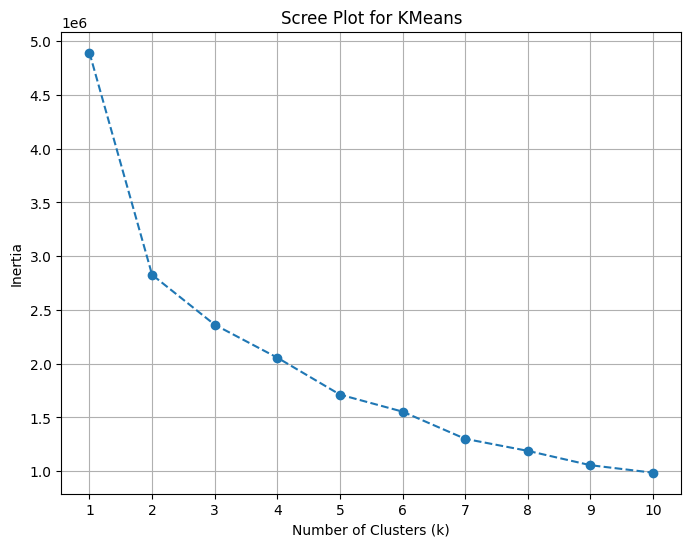

In [9]:
#Elbow method for n_clusters

import matplotlib.pyplot as plt
from sklearn.cluster import KMeans


inertia = []

cluster_range = range(1, 11)

#Fit on PCA reduced data
for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(airbnb_reduced)
    inertia.append(kmeans.inertia_)


plt.figure(figsize=(8, 6))
plt.plot(cluster_range, inertia, marker='o', linestyle='--')
plt.title('Scree Plot for KMeans')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.xticks(cluster_range)
plt.grid(True)
plt.show()


Elbow appears at n=2.

In [10]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np

#2 Clusters

#Evaluate for k=2, based on above graph
kmeans_k2 = KMeans(n_clusters=2, random_state=42)
airbnb['kmeans_cluster_k2'] = kmeans_k2.fit_predict(airbnb_reduced)

#Silhouette score for k=2
silhouette_k2 = silhouette_score(airbnb_reduced, airbnb['kmeans_cluster_k2'])
print(f"Silhouette Score for KMeans with k=2: {silhouette_k2}")

#Flag anomalies for k=2
distances_k2 = np.min(kmeans_k2.transform(airbnb_reduced), axis=1)
threshold_k2 = np.percentile(distances_k2, 95)
airbnb['kmeans_anomaly_k2'] = (distances_k2 > threshold_k2).astype(int)


#Try 3 Clusters for comparison

#k=3
kmeans_k3 = KMeans(n_clusters=3, random_state=42)
airbnb['kmeans_cluster_k3'] = kmeans_k3.fit_predict(airbnb_reduced)

#Silhouette score
silhouette_k3 = silhouette_score(airbnb_reduced, airbnb['kmeans_cluster_k3'])
print(f"Silhouette Score for KMeans with k=3: {silhouette_k3}")

#Flag anomalies
distances_k3 = np.min(kmeans_k3.transform(airbnb_reduced), axis=1)
threshold_k3 = np.percentile(distances_k3, 95)
airbnb['kmeans_anomaly_k3'] = (distances_k3 > threshold_k3).astype(int)


Silhouette Score for KMeans with k=2: 0.8488303433199951
Silhouette Score for KMeans with k=3: 0.47107620741817596


As expected, 2 clusters performed better than 3 clusters.

#### KMeans without PCA

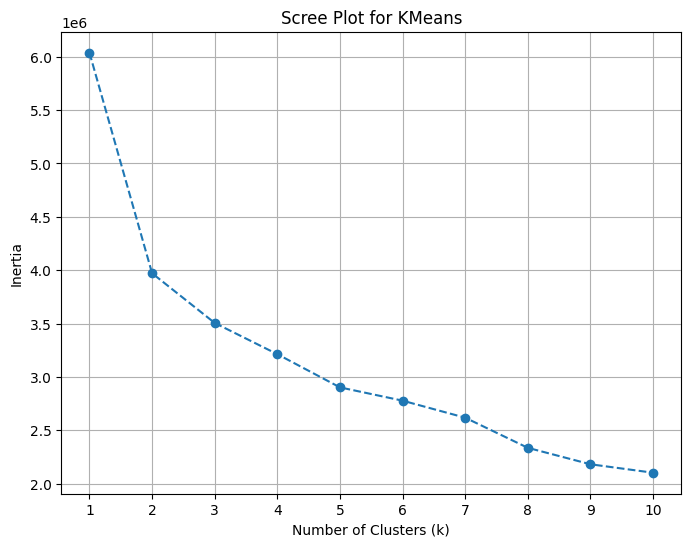

In [11]:
#Elbow method for n_clusters

import matplotlib.pyplot as plt
from sklearn.cluster import KMeans


inertia = []

cluster_range = range(1, 11)

#Fit on original preprocessed data
for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(airbnb_processed)
    inertia.append(kmeans.inertia_)


plt.figure(figsize=(8, 6))
plt.plot(cluster_range, inertia, marker='o', linestyle='--')
plt.title('Scree Plot for KMeans')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.xticks(cluster_range)
plt.grid(True)
plt.show()


Elbow at k=2 again.

In [12]:
#Kmeans without PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np

#2 clusters

#Evaluate for k=2
kmeans_k2 = KMeans(n_clusters=2, random_state=42)
airbnb['kmeans_cluster_k2'] = kmeans_k2.fit_predict(airbnb_processed)

#Silhouette score for k=2
silhouette_k2 = silhouette_score(airbnb_processed, airbnb['kmeans_cluster_k2'])
print(f"Silhouette Score for KMeans with k=2: {silhouette_k2}")

#Flag anomalies for k=2
distances_k2 = np.min(kmeans_k2.transform(airbnb_processed), axis=1)
threshold_k2 = np.percentile(distances_k2, 95)
airbnb['kmeans_anomaly_k2'] = (distances_k2 > threshold_k2).astype(int)


#Try 3 clusters for comparison

#k=3
kmeans_k3 = KMeans(n_clusters=3, random_state=42)
airbnb['kmeans_cluster_k3'] = kmeans_k3.fit_predict(airbnb_processed)

#Silhouette
silhouette_k3 = silhouette_score(airbnb_processed, airbnb['kmeans_cluster_k3'])
print(f"Silhouette Score for KMeans with k=3: {silhouette_k3}")

#Flag anomalies
distances_k3 = np.min(kmeans_k3.transform(airbnb_processed), axis=1)
threshold_k3 = np.percentile(distances_k3, 95)
airbnb['kmeans_anomaly_k3'] = (distances_k3 > threshold_k3).astype(int)



Silhouette Score for KMeans with k=2: 0.8120306131572802
Silhouette Score for KMeans with k=3: 0.36304341657811456


Once again, 2 clusters outperformed 3, but the silhouette score was slightly better for the PCA model.

In [29]:
#Best Model - Kmeans with PCA and 2 clusters

#Evaluate for k=2
kmeans_k2 = KMeans(n_clusters=2, random_state=42)
airbnb['kmeans_cluster_k2'] = kmeans_k2.fit_predict(airbnb_reduced)

#Silhouette
silhouette_k2 = silhouette_score(airbnb_reduced, airbnb['kmeans_cluster_k2'])
print(f"Silhouette Score for KMeans with k=2: {silhouette_k2}")

#Flag anomalies
distances_k2 = np.min(kmeans_k2.transform(airbnb_reduced), axis=1)
threshold_k2 = np.percentile(distances_k2, 95)
airbnb['kmeans_anomaly_k2'] = (distances_k2 > threshold_k2).astype(int)

Silhouette Score for KMeans with k=2: 0.8488303433199951


## Model 3: DBSCAN

#### DBSCAN without PCA

In [31]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
import numpy as np

#First trial (eps=0.5, min_samples=20)
dbscan_1 = DBSCAN(eps=0.5, min_samples=20)
airbnb['dbscan_cluster_1'] = dbscan_1.fit_predict(airbnb_processed)

#Anomalies
airbnb['dbscan_anomaly_1'] = (airbnb['dbscan_cluster_1'] == -1).astype(int)

#Silhouette Score
dbscan_labels_1 = airbnb['dbscan_cluster_1']
silhouette_score_1 = silhouette_score(airbnb_processed, dbscan_labels_1)
print(f"Silhouette Score for DBSCAN (eps=0.5, min_samples=20): {silhouette_score_1}")

#Second trial (eps=0.7, min_samples=10)
dbscan_2 = DBSCAN(eps=0.7, min_samples=10)
airbnb['dbscan_cluster_2'] = dbscan_2.fit_predict(airbnb_processed)

#Anomalies
airbnb['dbscan_anomaly_2'] = (airbnb['dbscan_cluster_2'] == -1).astype(int)

#Silhouette Score
dbscan_labels_2 = airbnb['dbscan_cluster_2']
silhouette_score_2 = silhouette_score(airbnb_processed, dbscan_labels_2)
print(f"Silhouette Score for DBSCAN (eps=0.7, min_samples=10): {silhouette_score_2}")


Silhouette Score for DBSCAN (eps=0.5, min_samples=20): -0.2999653415499952
Silhouette Score for DBSCAN (eps=0.7, min_samples=10): -0.40799396878527483


Model fails to find any decent clustering with the original preprocessed data

#### DBSCAN with PCA

In [37]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
import numpy as np

#First trial (eps=0.5, min_samples=20)
dbscan_1 = DBSCAN(eps=0.5, min_samples=20)
airbnb['dbscan_cluster_1'] = dbscan_1.fit_predict(airbnb_reduced)

#Anomalies
airbnb['dbscan_anomaly_1'] = (airbnb['dbscan_cluster_1'] == -1).astype(int)

#Silhouette Score
dbscan_labels_1 = airbnb['dbscan_cluster_1']
silhouette_score_1 = silhouette_score(airbnb_reduced, dbscan_labels_1)
print(f"Silhouette Score for DBSCAN (eps=0.5, min_samples=20): {silhouette_score_1}")

#Second trial (eps=1.5, min_samples=20)
dbscan_2 = DBSCAN(eps=1.5, min_samples=20)
airbnb['dbscan_cluster_2'] = dbscan_2.fit_predict(airbnb_reduced)

#Anomalies
airbnb['dbscan_anomaly_2'] = (airbnb['dbscan_cluster_2'] == -1).astype(int)

#Silhouette Score
dbscan_labels_2 = airbnb['dbscan_cluster_2']
silhouette_score_2 = silhouette_score(airbnb_reduced, dbscan_labels_2)
print(f"Silhouette Score for DBSCAN (eps=1.5, min_samples=20): {silhouette_score_2}")


Both trials performed better with the PCA reduced data, with trial 2 having a silhouette score of 0.82.

In [36]:
#Best Model - DBSCAN trial 2 with PCA


#Second trial (eps=1.5, min_samples=20)
dbscan_2 = DBSCAN(eps=1.5, min_samples=20)
airbnb['dbscan_cluster_2'] = dbscan_2.fit_predict(airbnb_reduced)

#Label
airbnb['dbscan_anomaly_2'] = (airbnb['dbscan_cluster_2'] == -1).astype(int)

#Silhouette 
dbscan_labels_2 = airbnb['dbscan_cluster_2']
silhouette_score_2 = silhouette_score(airbnb_reduced, dbscan_labels_2)
print(f"Silhouette Score for DBSCAN (eps=1.5, min_samples=20): {silhouette_score_2}")

# Identify Anomalies 

We will use the best model of each method to attempt to cluster and flag anomalies.

In [17]:
#View listing ids of any properties flagged

listing_ids = airbnb['id']


anomalies = airbnb[(airbnb['isolation_forest_anomaly'] == -1) | 
                   (airbnb['kmeans_anomaly_k2'] == 1) | 
                   (airbnb['dbscan_anomaly_1'] == 1)]

#Count the number of anomalies
count = anomalies[anomalies['id'].isin(listing_ids)].shape[0]

print(f"Anomalies Flagged: {count}")

In [49]:
#Listings flagged by all three models

all_three_flagged = airbnb[(airbnb['isolation_forest_anomaly'] == -1) & 
                           (airbnb['kmeans_anomaly_k2'] == 1) & 
                           (airbnb['dbscan_anomaly_1'] == 1)]



#Show columns
columns_to_display = ['id', 'isolation_forest_anomaly', 'kmeans_anomaly_k2', 'dbscan_anomaly_1']

print(all_three_flagged[columns_to_display].to_string(index=False))


                 id  isolation_forest_anomaly  kmeans_anomaly_k2  dbscan_anomaly_1
             659331                        -1                  1                 1
            4752017                        -1                  1                 1
            5115728                        -1                  1                 1
            4857597                        -1                  1                 1
            6317289                        -1                  1                 1
            9964118                        -1                  1                 1
            9577136                        -1                  1                 1
           10283009                        -1                  1                 1
           10713346                        -1                  1                 1
           10752023                        -1                  1                 1
           11017250                        -1                  1                 1
    

In [48]:
#Filter the original DataFrame using the flagged IDs
flagged_ids = all_three_flagged['id'].unique()
filtered_airbnb = airbnb[airbnb['id'].isin(flagged_ids)]

#Print selected columns
columns_to_display = ['id','name','listing_url', 'host_id', 'price', 'isolation_forest_anomaly', 'kmeans_anomaly_k2', 'dbscan_anomaly_1']  # Example columns
print(filtered_airbnb[columns_to_display].to_string(index=False))


                 id                                               name                                      listing_url   host_id     price  isolation_forest_anomaly  kmeans_anomaly_k2  dbscan_anomaly_1
             659331                                       Hale Maluhia              https://www.airbnb.com/rooms/659331   2845098   $119.00                        -1                  1                 1
            4752017    Cozy Beach Cottage/30 day minimum stay required             https://www.airbnb.com/rooms/4752017  24522316   $325.00                        -1                  1                 1
            5115728          Yurt Waihuena Farm  MONTHLY bookings only             https://www.airbnb.com/rooms/5115728    770461    $50.00                        -1                  1                 1
            4857597                          Waikiki Marina Resort (3)             https://www.airbnb.com/rooms/4857597  22267033   $292.00                        -1                  1    

Preliminary evaluation of the distribution of flagged listings:

Interesting distributions of note for flagged properties:
- Most flagged properties have hosts with few listed properties
- Most flagged properties have very low number of reviews
- Most flagged properties have hosts with verified profiles and pictures
- Most flagged properties have low host response rates
- Most flagged properties do not have hosts with a superhost badge
- Most flagged properties have below average list price

/tmp/ipykernel_3342/2825276874.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_airbnb.drop(columns=columns_to_drop, inplace=True, errors='ignore')


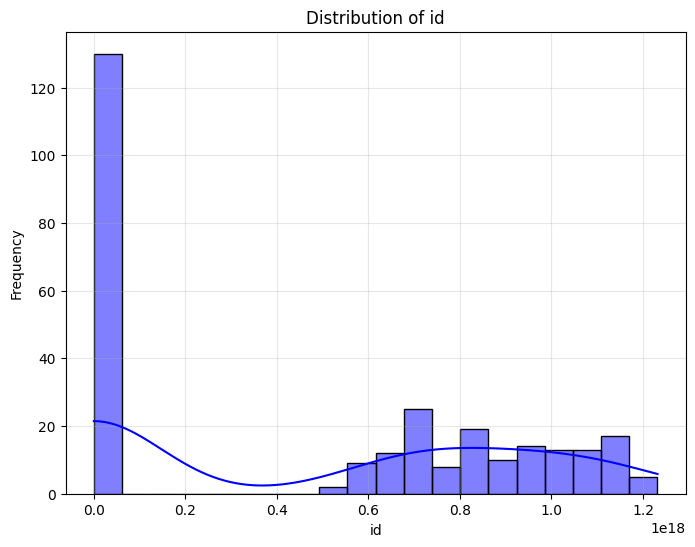

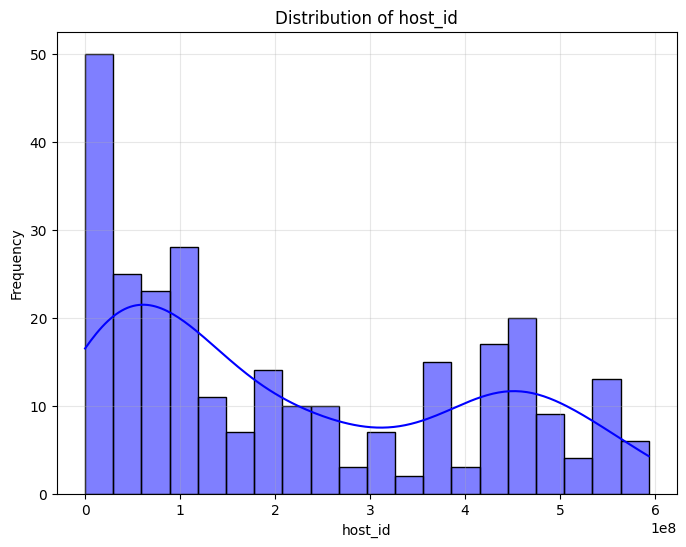

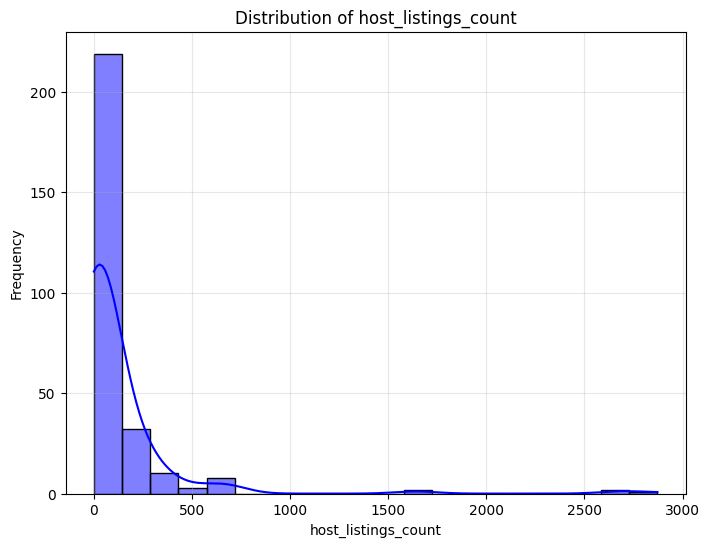

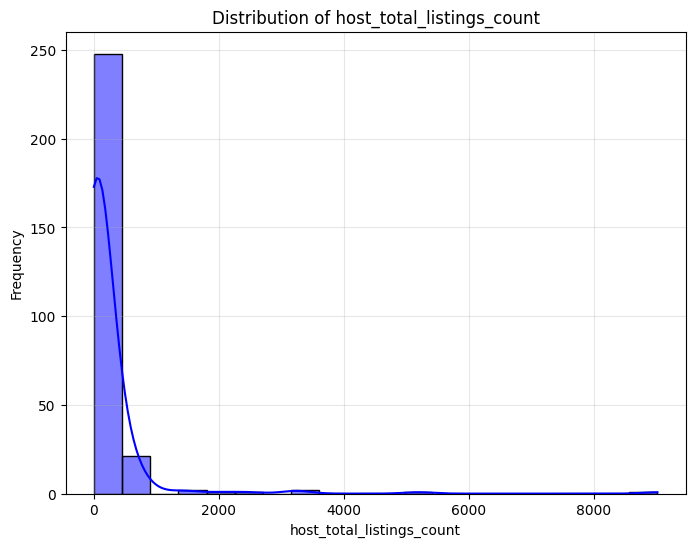

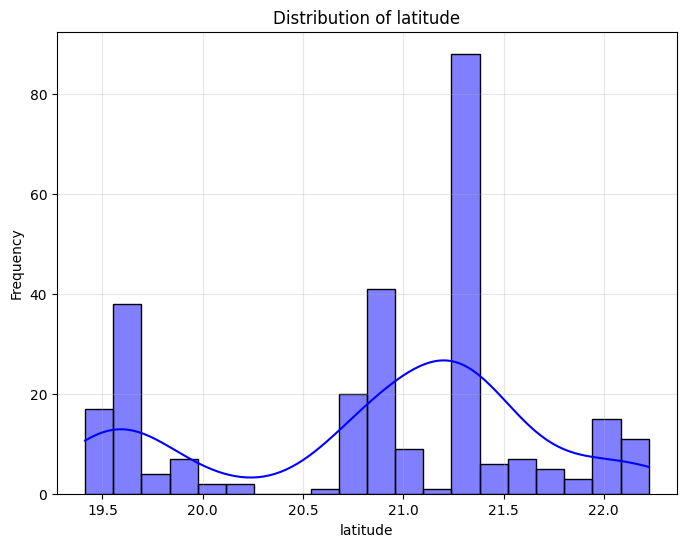

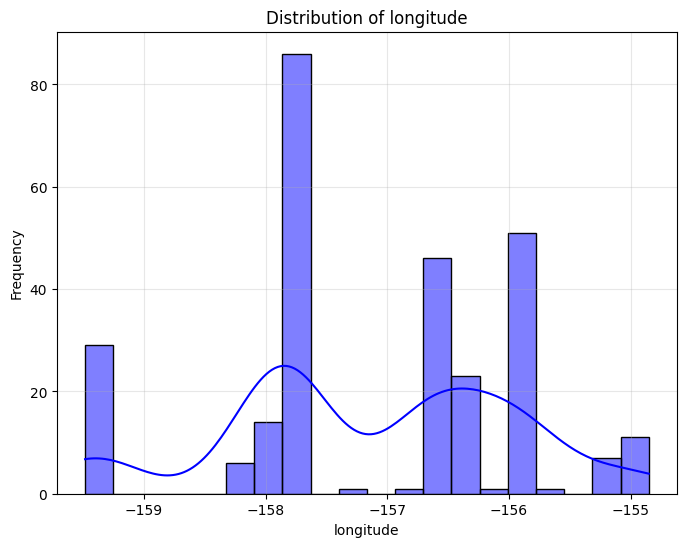

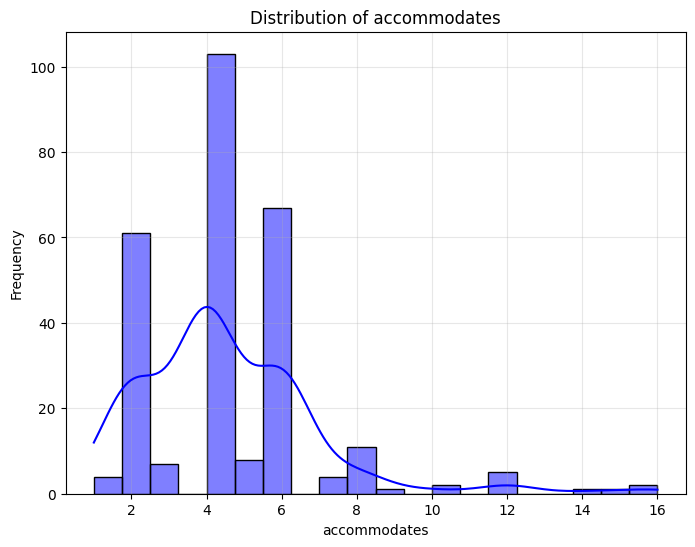

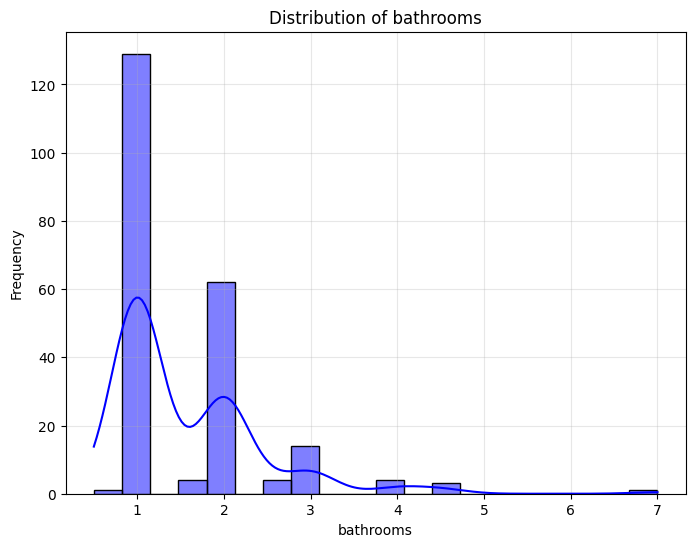

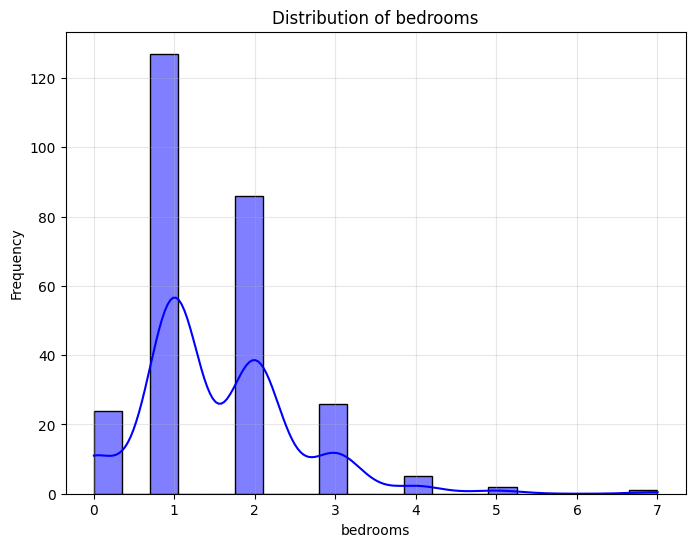

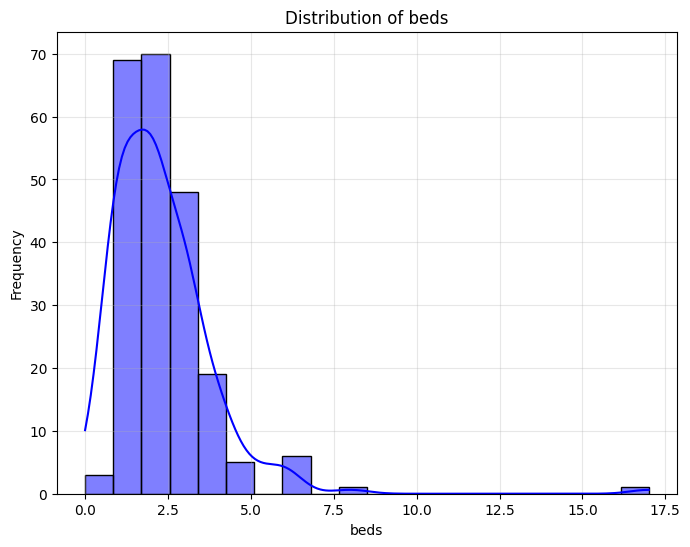

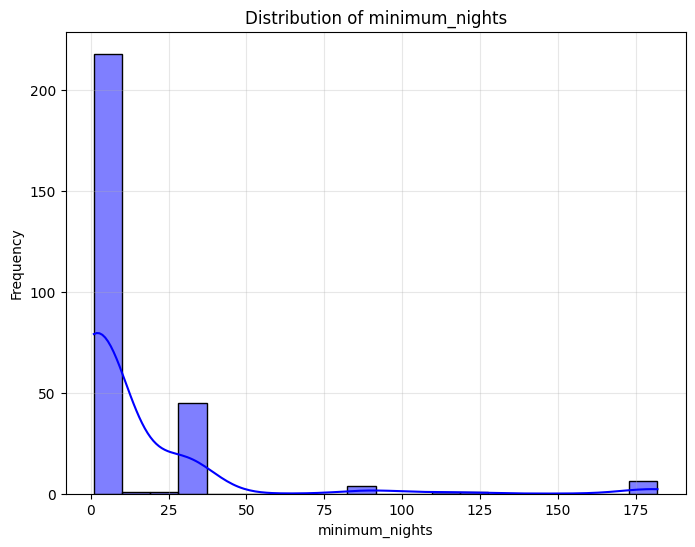

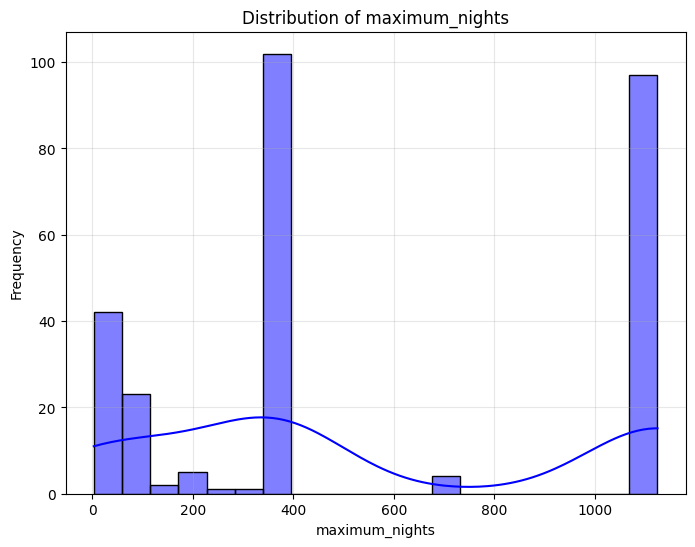

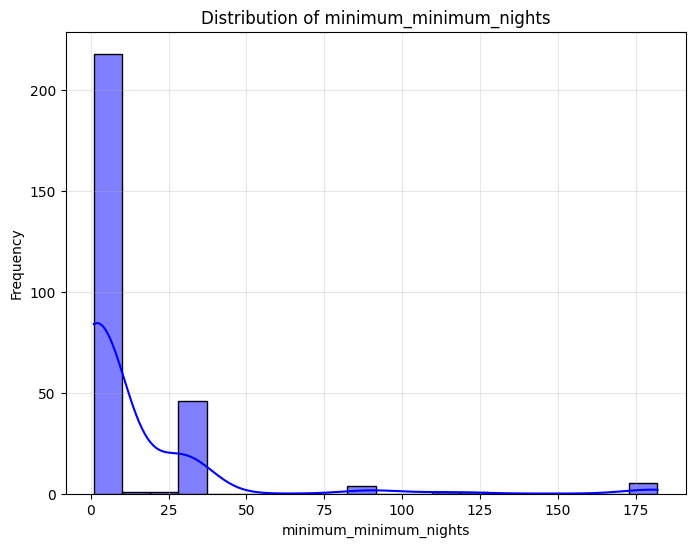

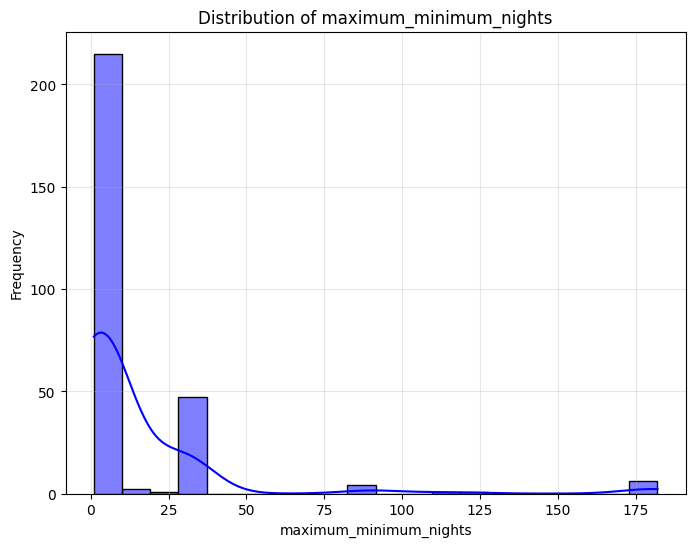

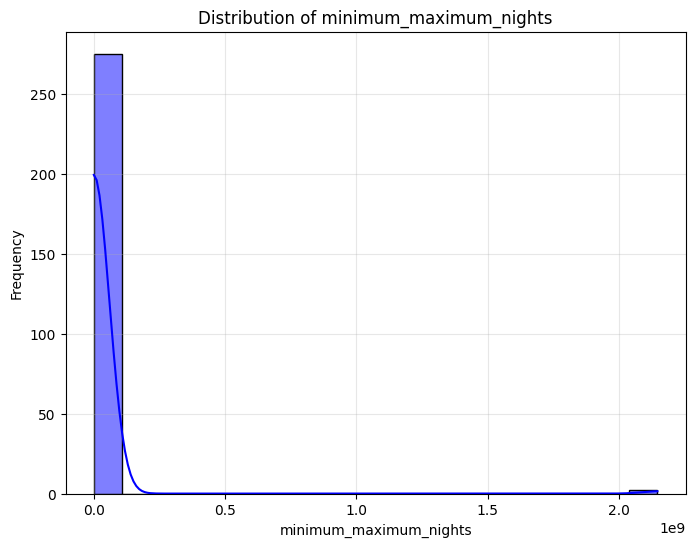

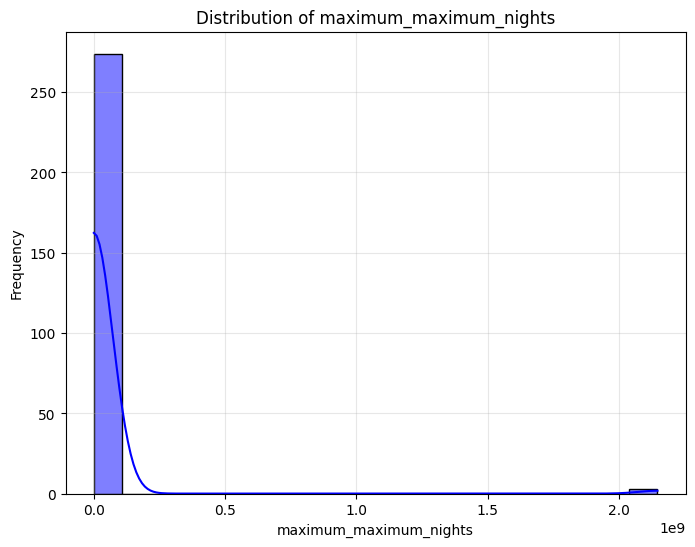

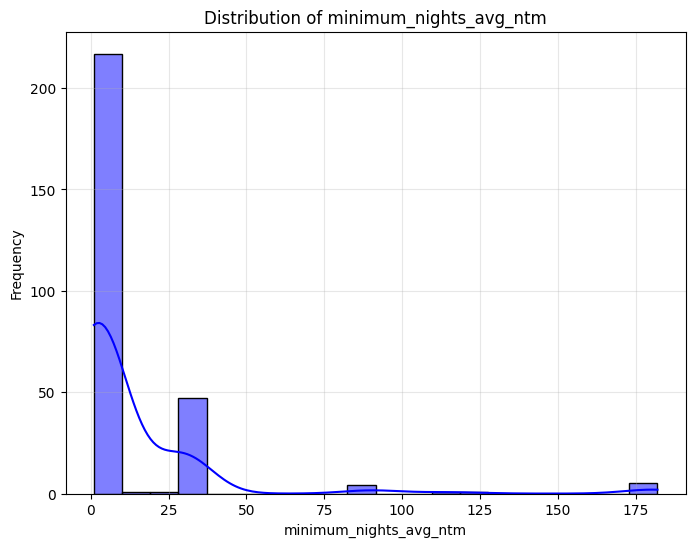

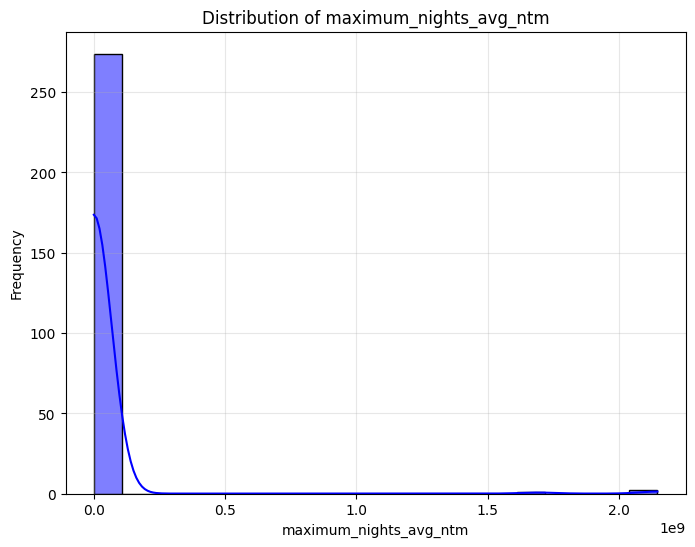

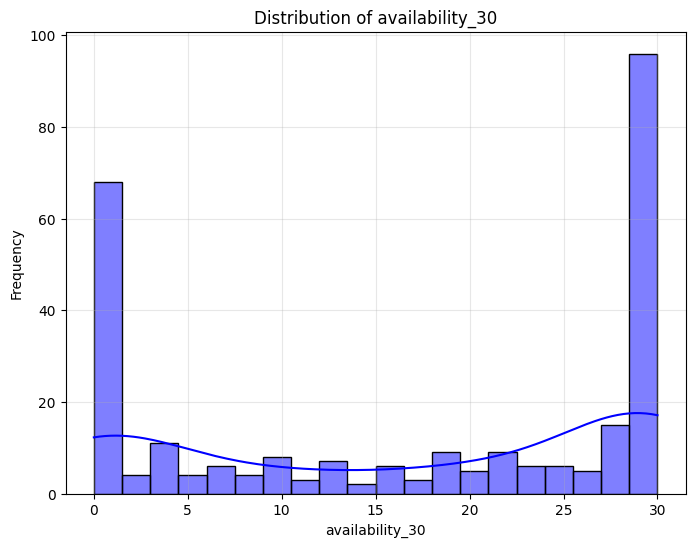

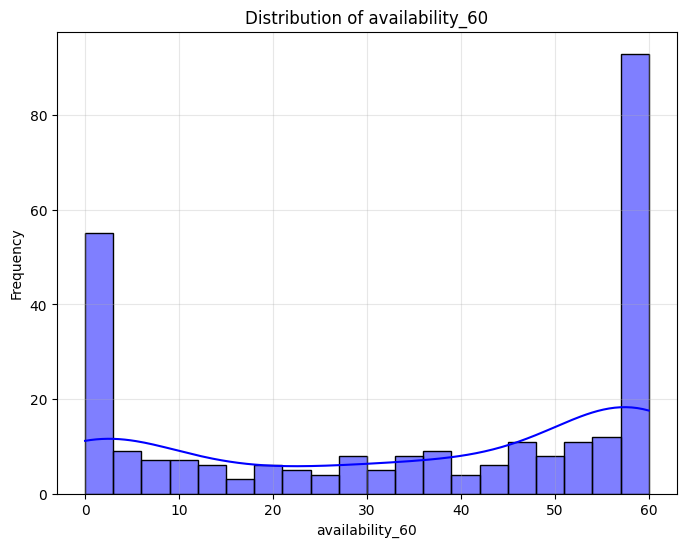

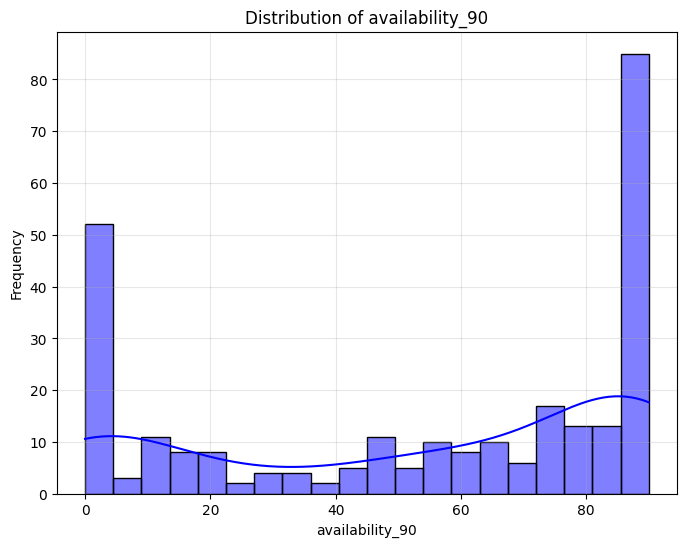

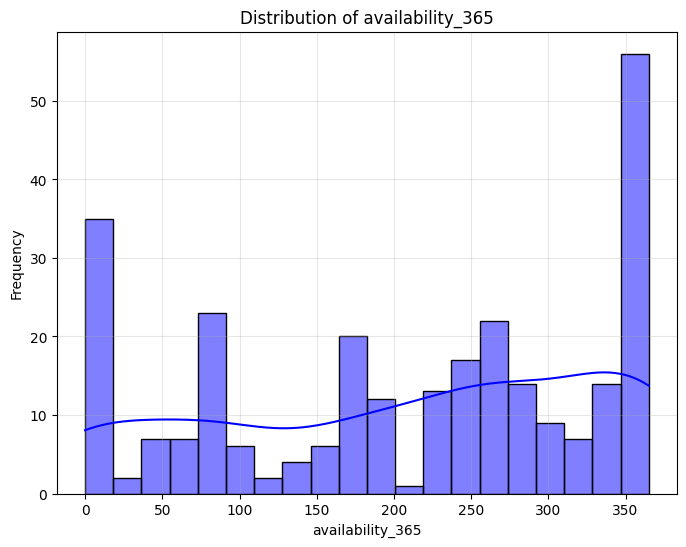

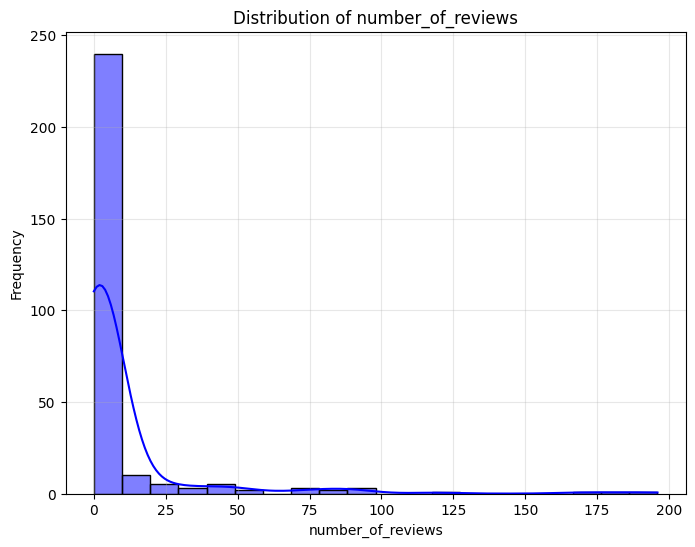

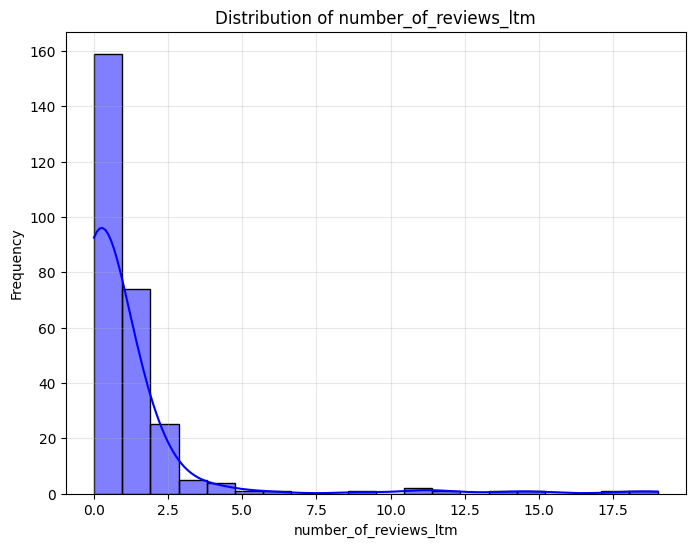

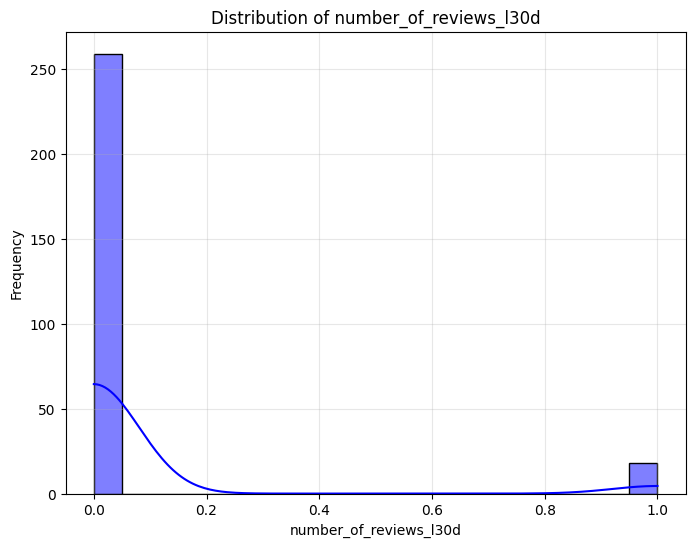

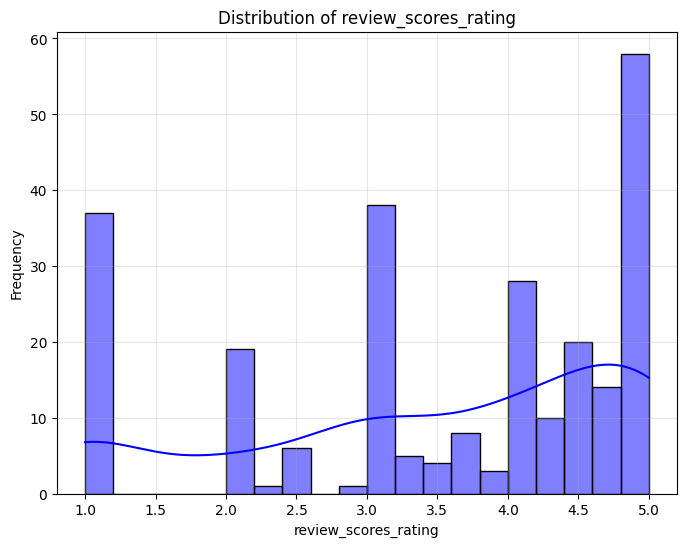

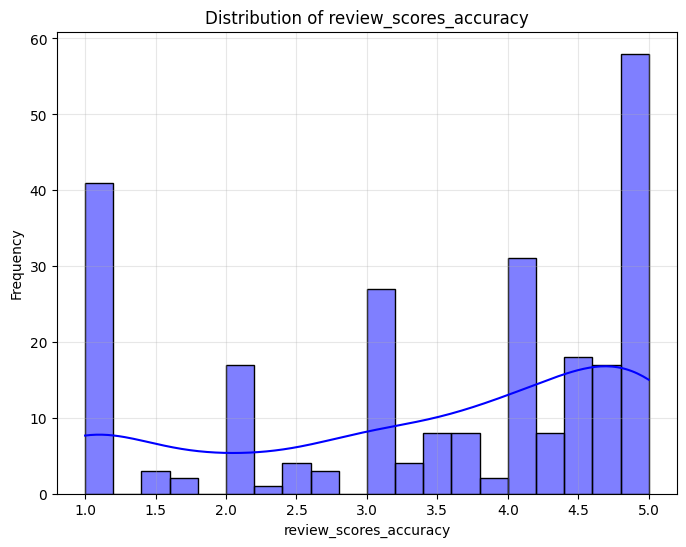

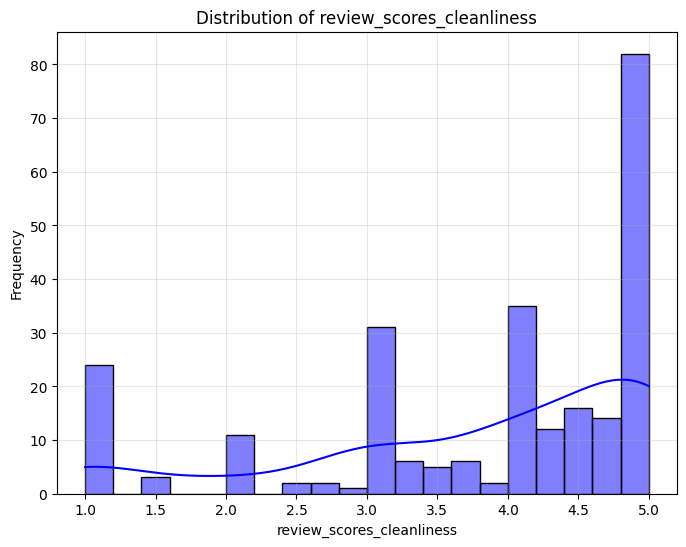

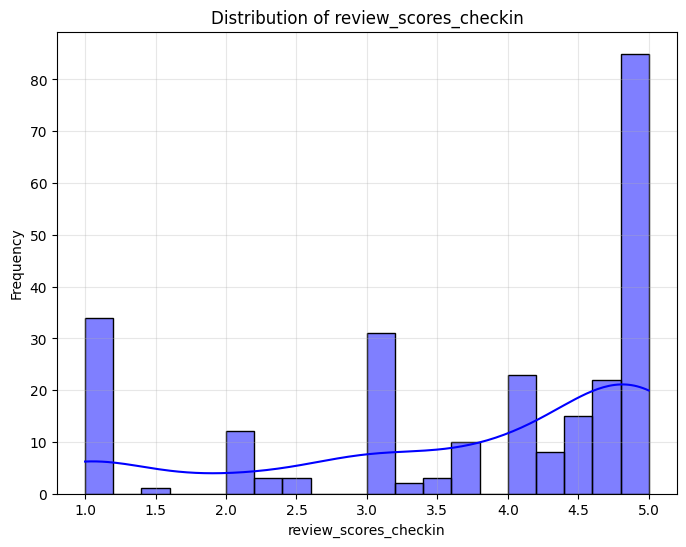

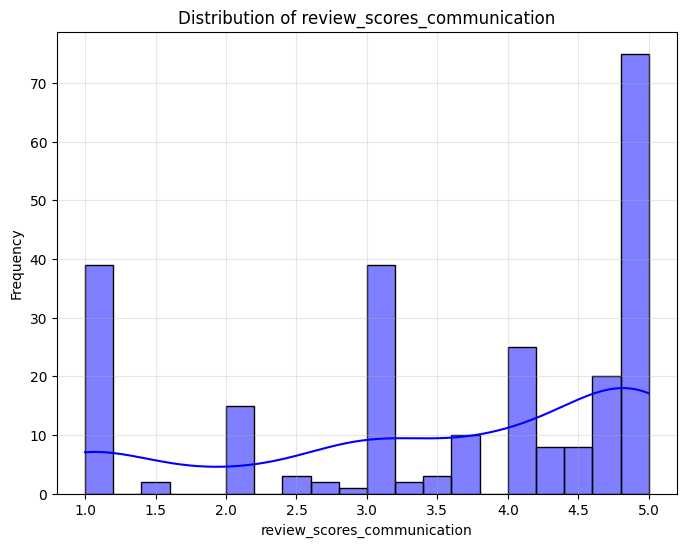

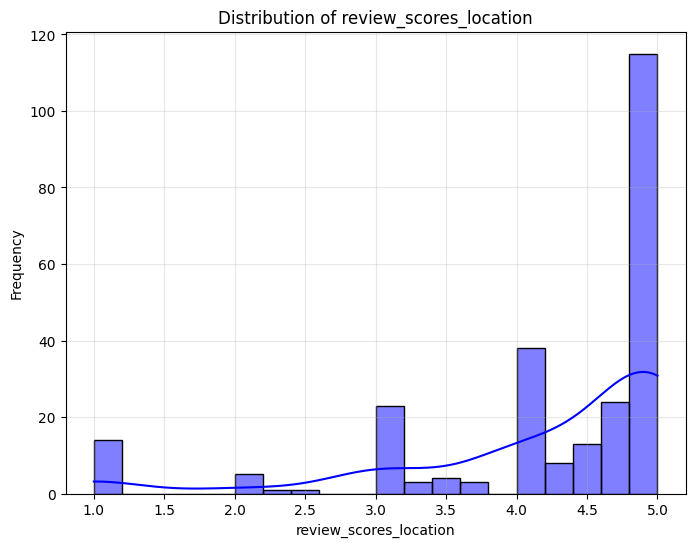

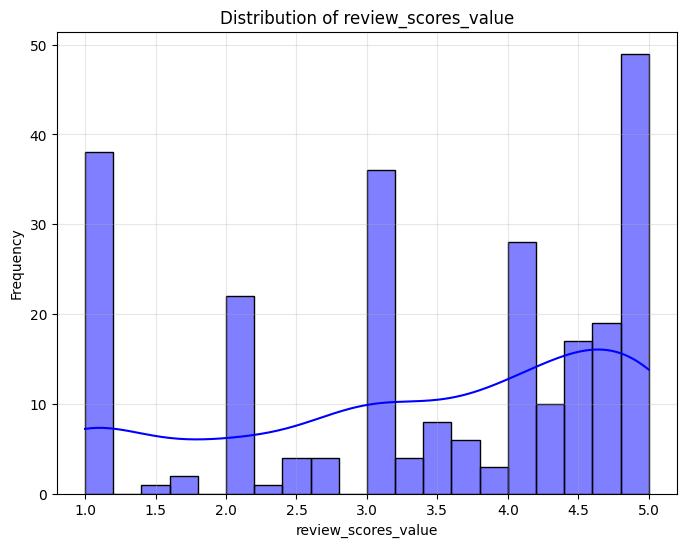

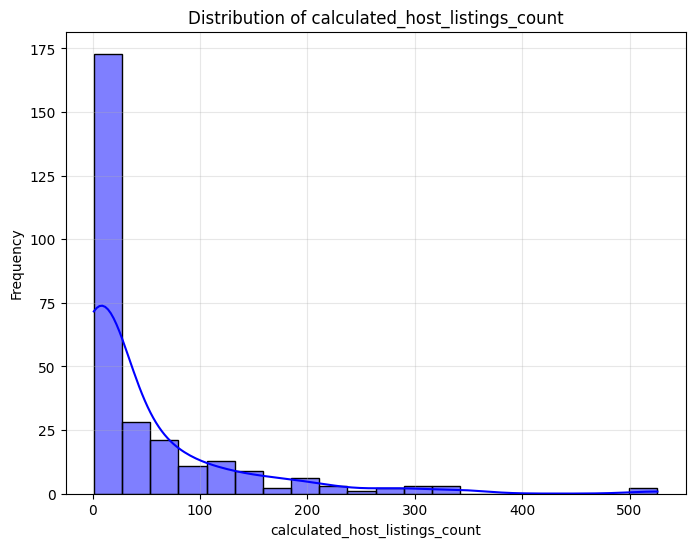

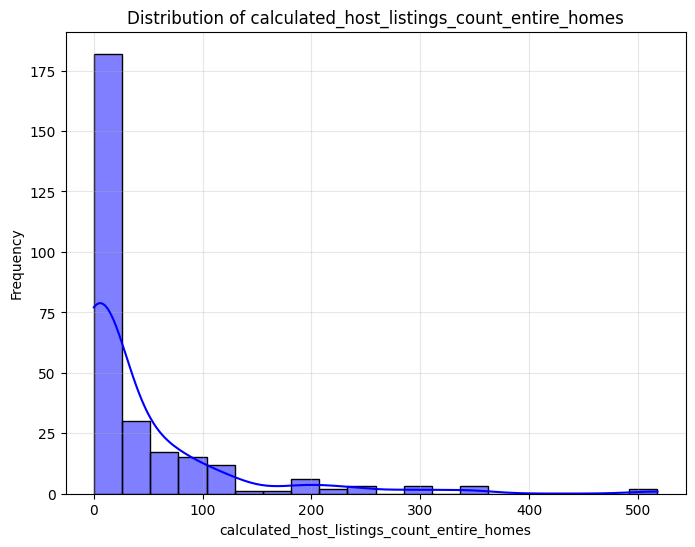

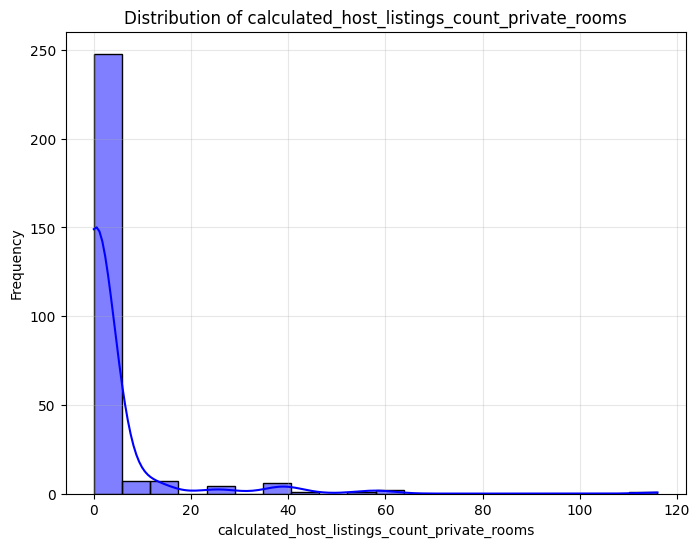

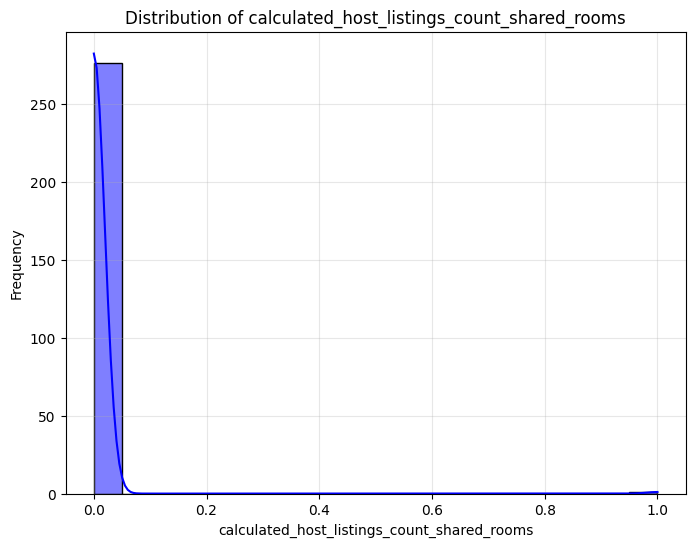

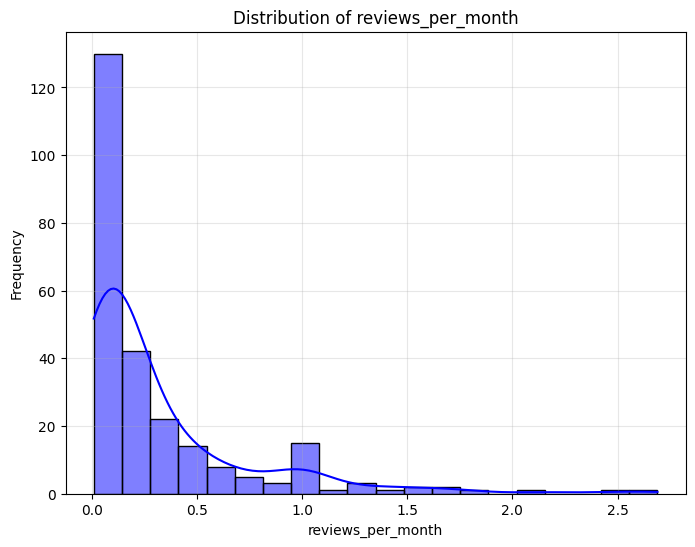

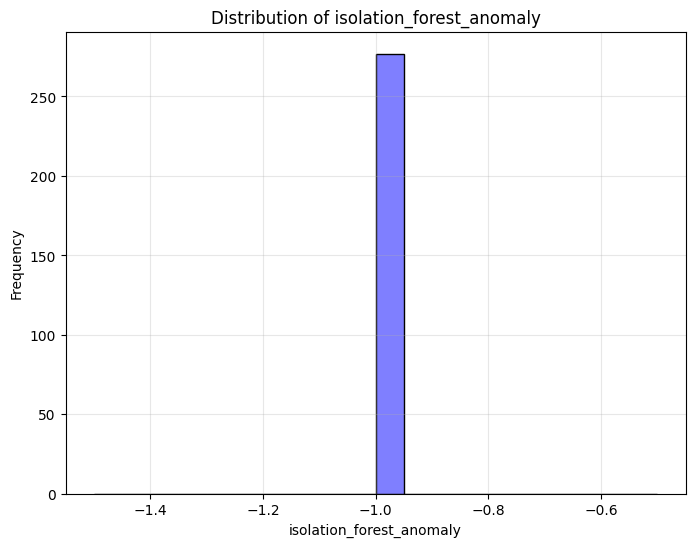

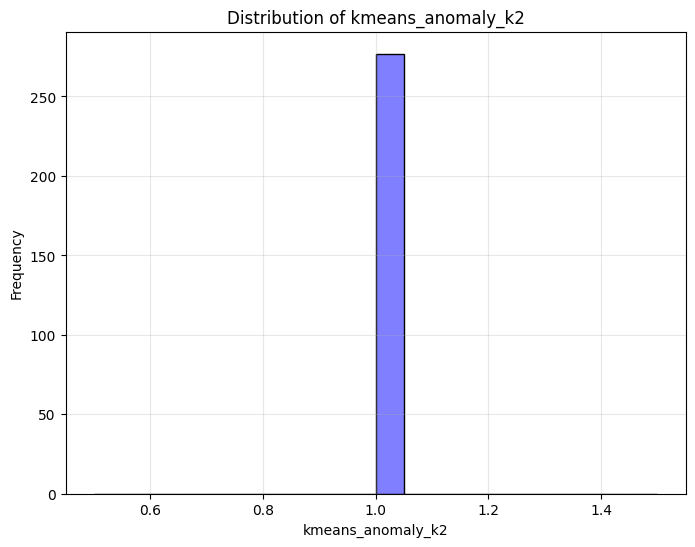

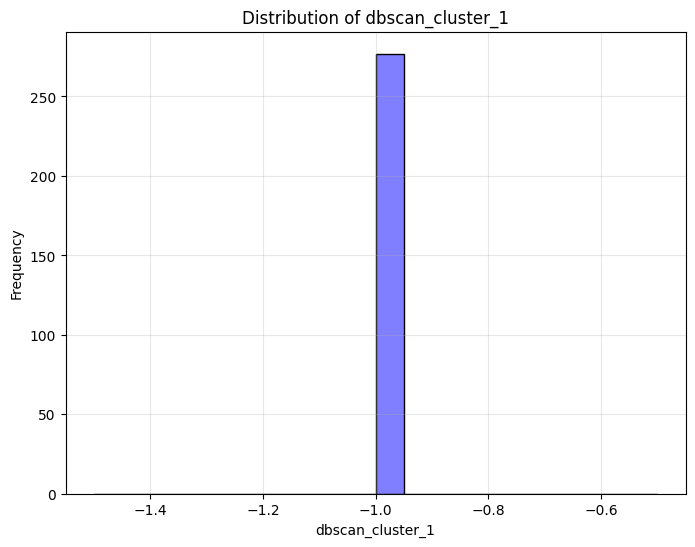

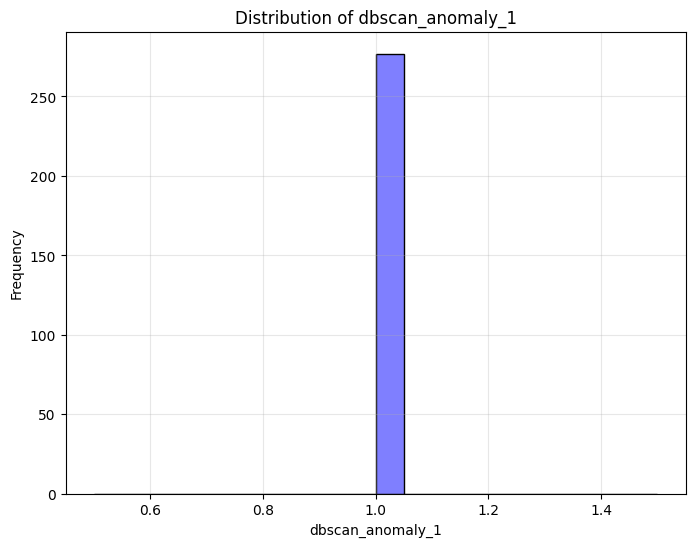

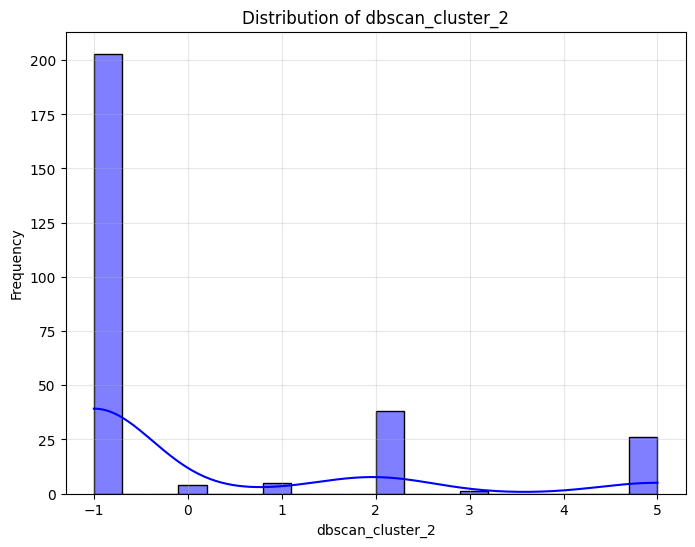

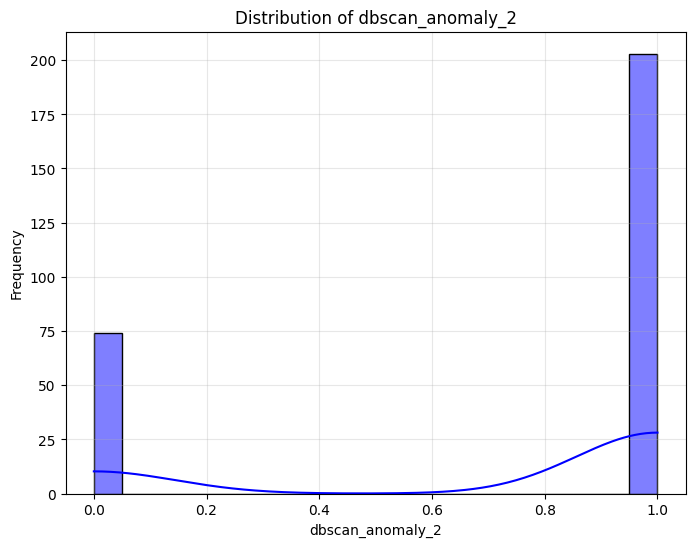

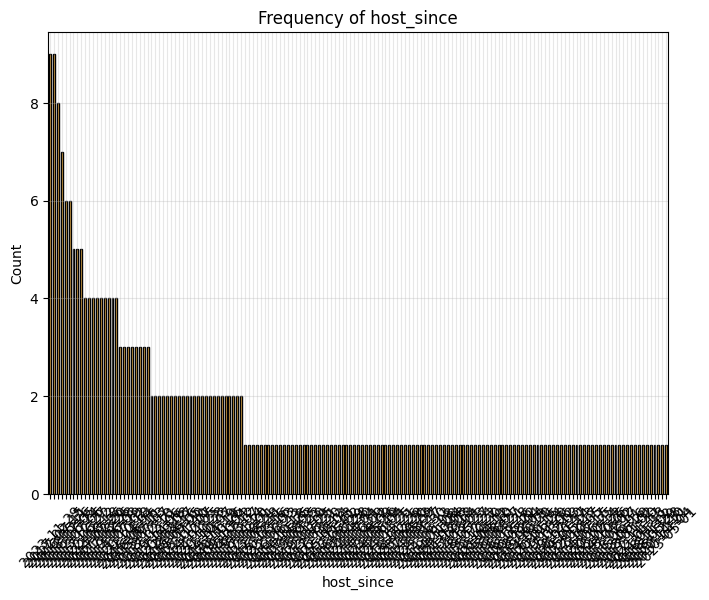

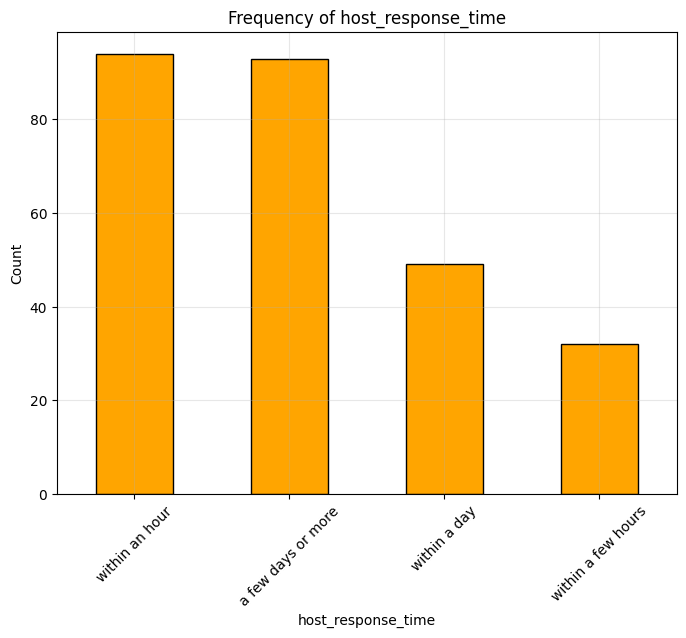

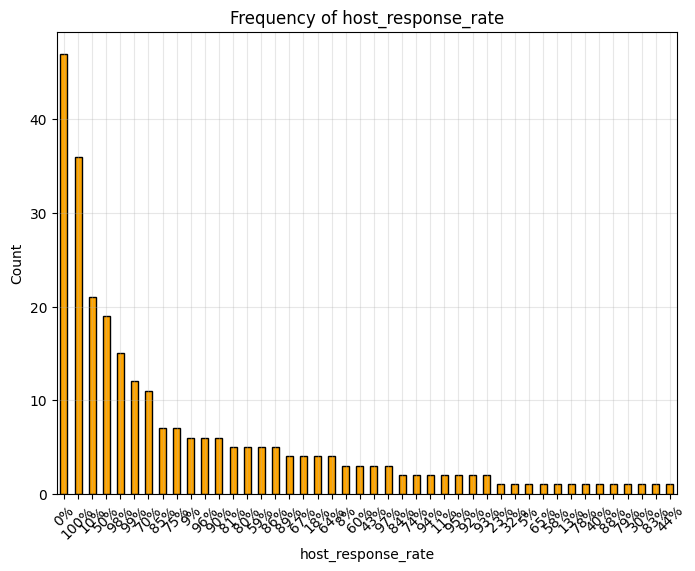

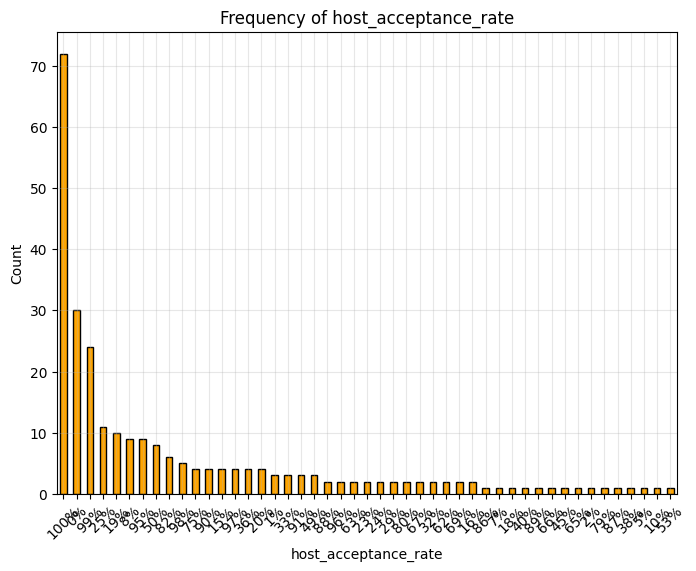

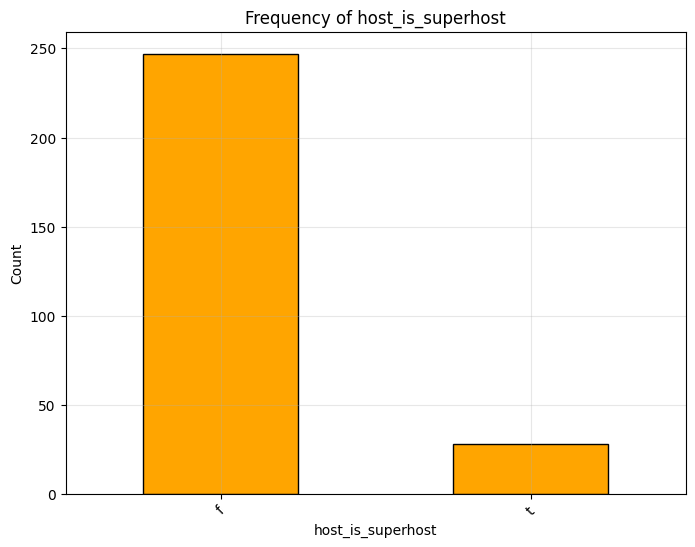

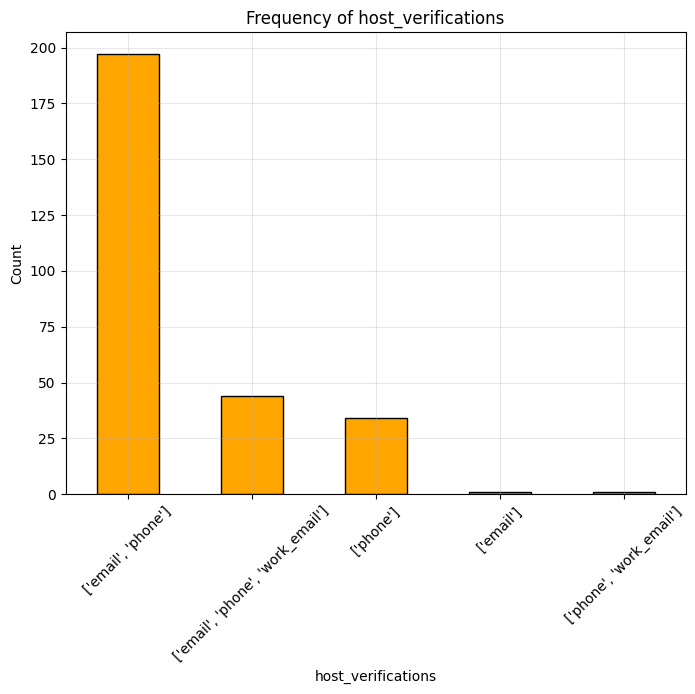

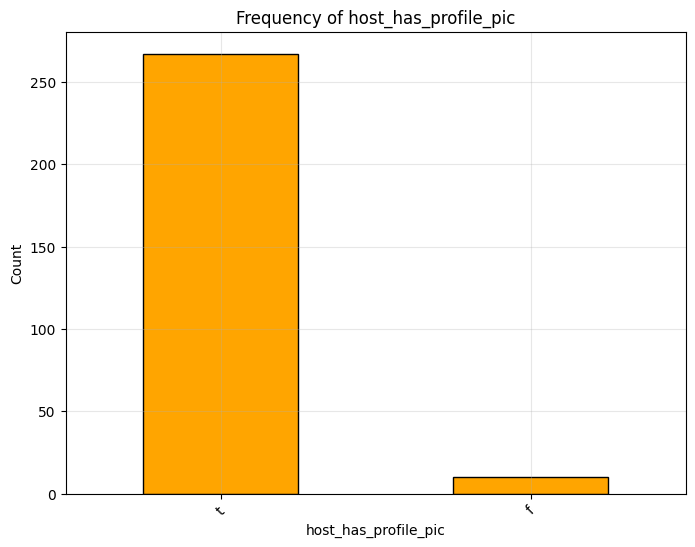

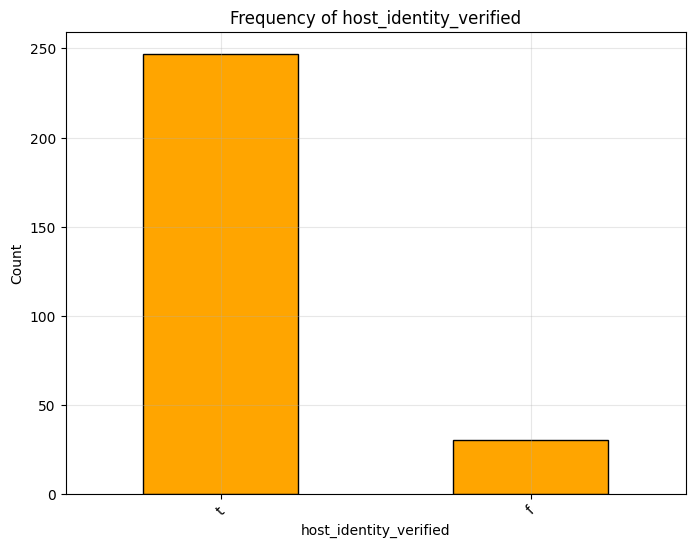

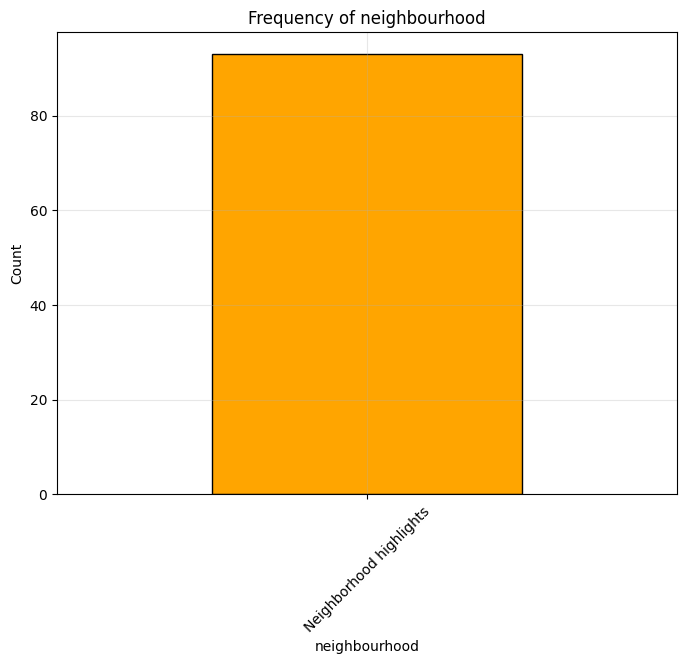

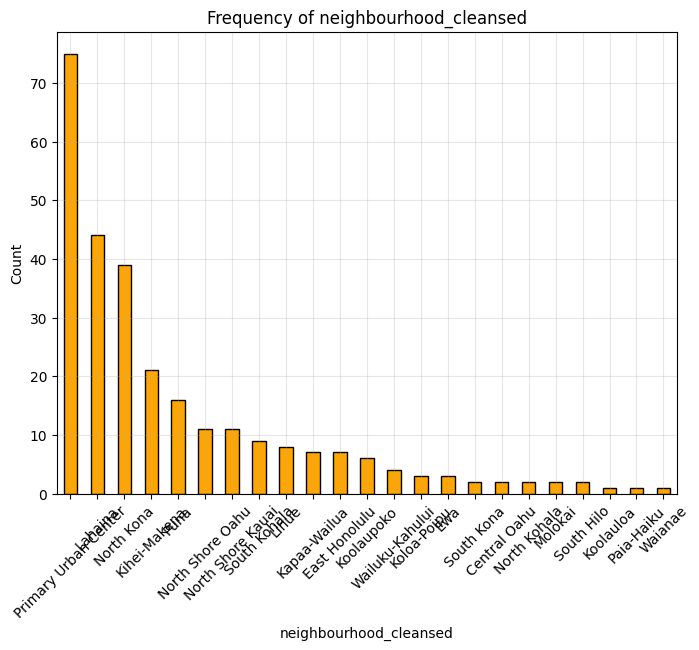

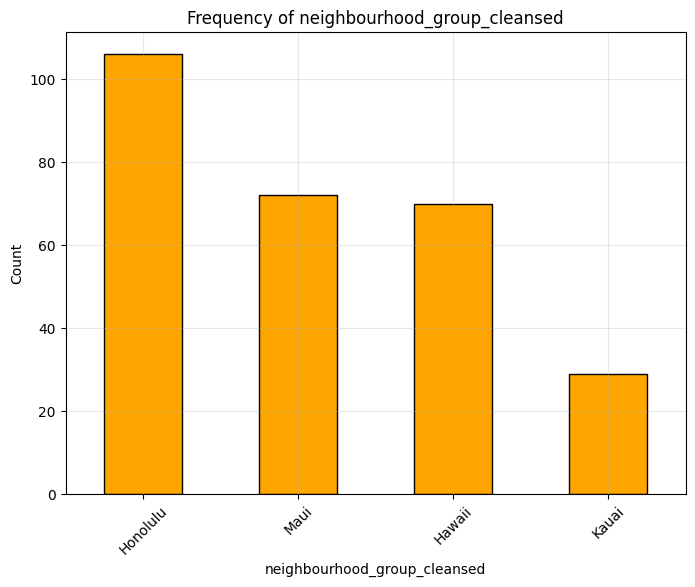

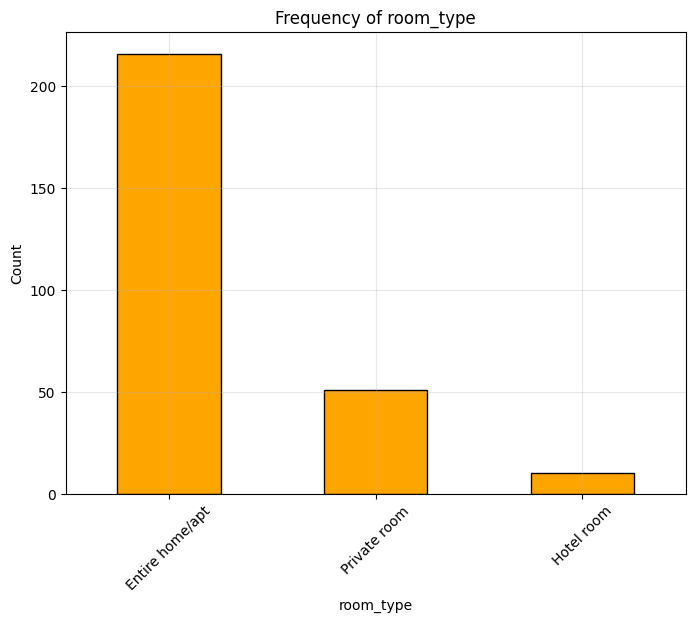

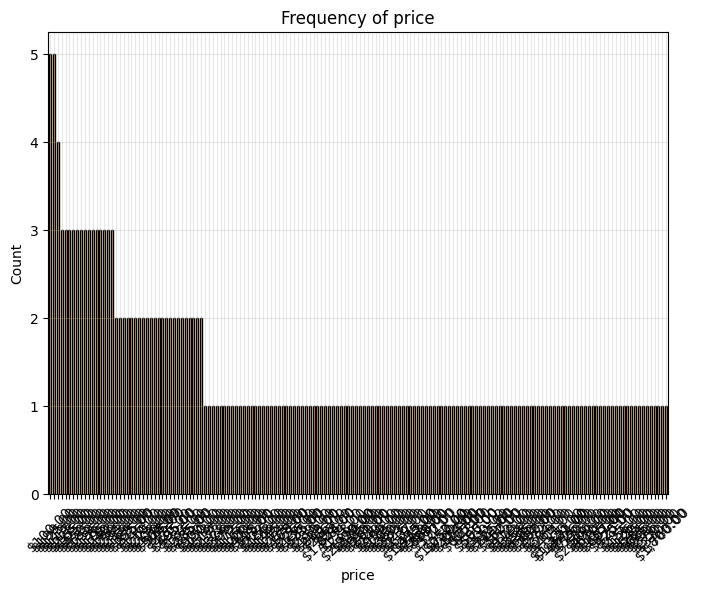

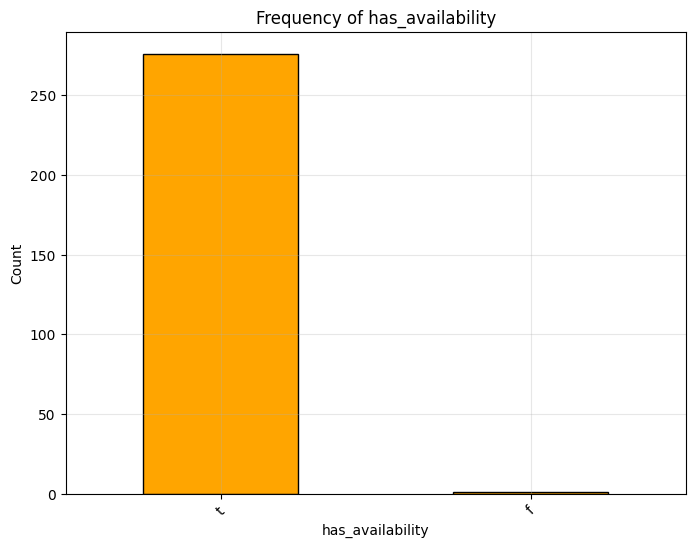

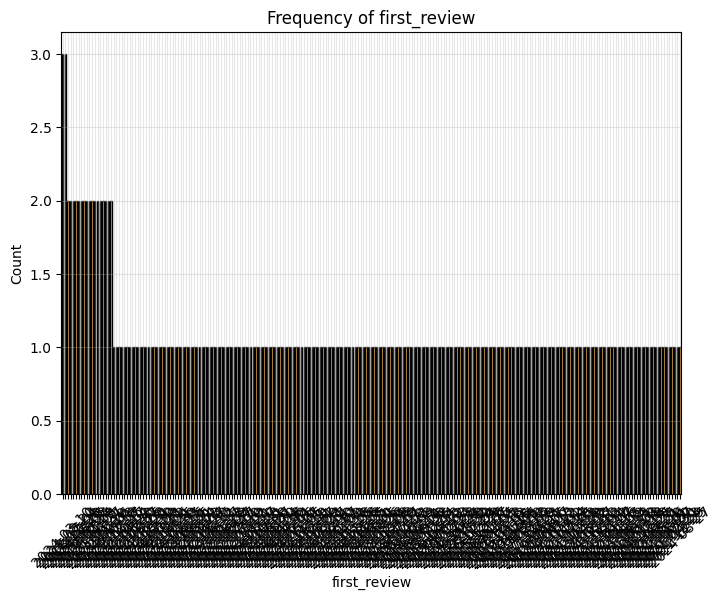

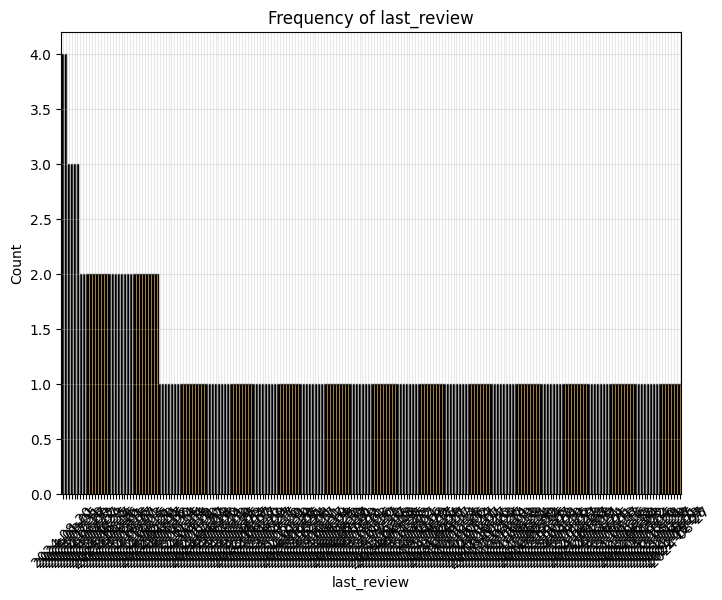

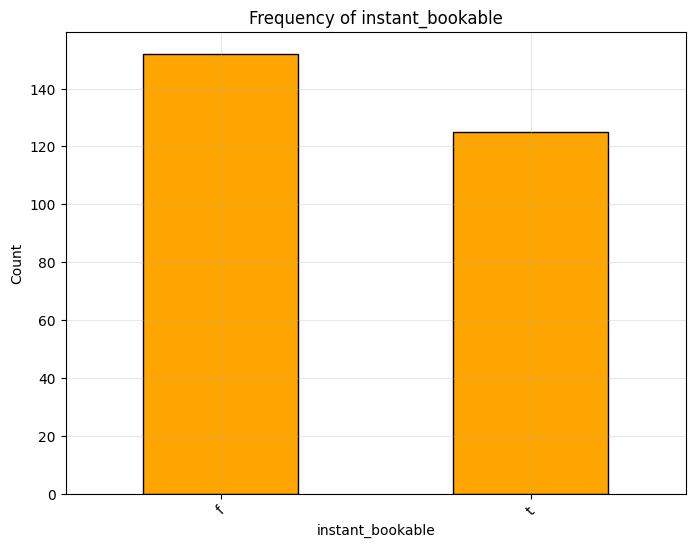

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns

#Separate numerical and categorical columns

columns_to_drop = [
    'listing_url', 'scrape_id', 'last_scraped', 'source', 
    'picture_url', 'host_url', 'host_thumbnail_url', 'host_picture_url',
    'calendar_updated', 'calendar_last_scraped', 'bathrooms_text',"name", 
    "description", "neighborhood_overview", "host_name", "host_about", "amenities", 'license', 
    'host_neighbourhood', 'host_location', 'property_type'
]
filtered_airbnb.drop(columns=columns_to_drop, inplace=True, errors='ignore')

numerical_columns = filtered_airbnb.select_dtypes(include=['float64', 'int64']).columns
categorical_columns = filtered_airbnb.select_dtypes(include=['object', 'category']).columns

#Create histograms
for col in numerical_columns:
    plt.figure(figsize=(8, 6))
    sns.histplot(filtered_airbnb[col].dropna(), bins=20, kde=True, color='blue')
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.grid(alpha=0.3)
    plt.show()

#Bar charts for categorical columns
for col in categorical_columns:
    plt.figure(figsize=(8, 6))
    filtered_airbnb[col].value_counts().plot(kind='bar', color='orange', edgecolor='k')
    plt.title(f'Frequency of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.grid(alpha=0.3)
    plt.show()


# Evaluation and Visualization

Note: Blue represents anomaly (-1) for IsoForest

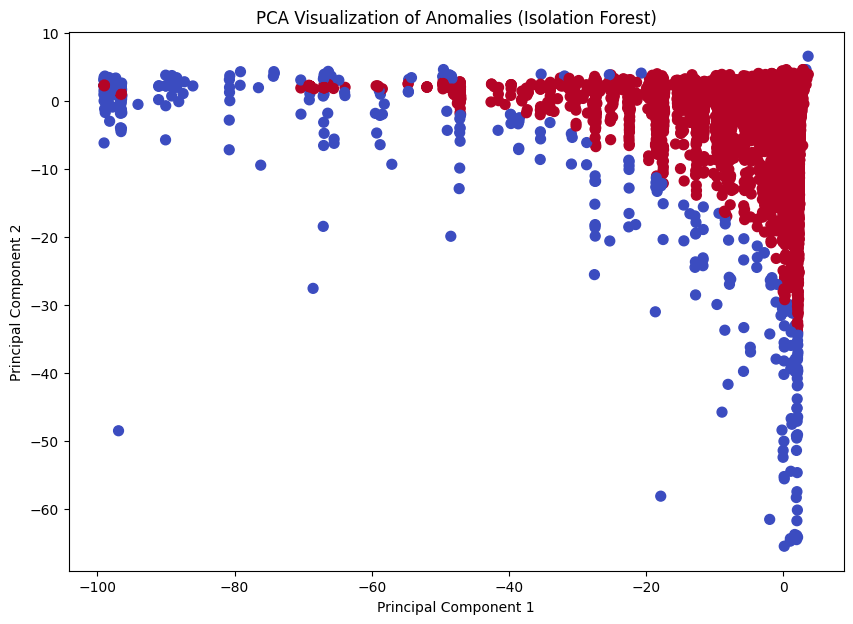

In [50]:
#Isoforest Visualization with PCA

#PCA
pca = PCA(n_components=2, random_state=42)
airbnb_reduced = pca.fit_transform(airbnb_processed)

#Isoforest
plt.figure(figsize=(10, 7))
plt.scatter(airbnb_reduced[:, 0], airbnb_reduced[:, 1], c=airbnb['isolation_forest_anomaly'], cmap='coolwarm', s=50)
plt.title("PCA Visualization of Anomalies (Isolation Forest)")
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()


/anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


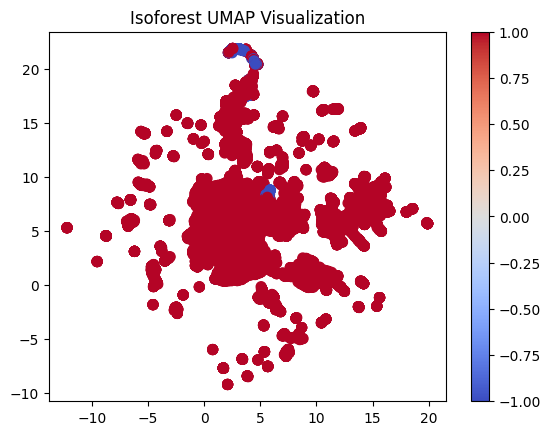

In [51]:
#Isoforest UMAP Visualization

#%pip install umap-learn
import umap
import matplotlib.pyplot as plt

#Apply UMAP
reducer = umap.UMAP(random_state=42)
X_umap = reducer.fit_transform(airbnb_processed)

#Plot
plt.scatter(X_umap[:, 0], X_umap[:, 1], c=airbnb['isolation_forest_anomaly'], cmap='coolwarm', s=50)
plt.colorbar()
plt.title("Isoforest UMAP Visualization")
plt.show()


Both PCA and UMAP do not provide great visualizations.

Note: Red represents anomalies for KMeans

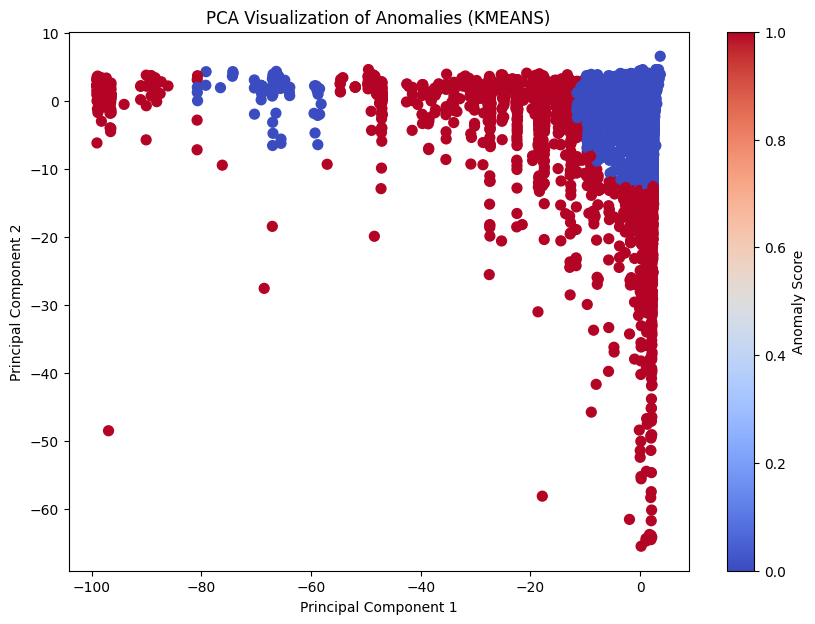

In [52]:
#Plot Kmeans with PCA visualization

#PCA
pca = PCA(n_components=2, random_state=42)
airbnb_reduced = pca.fit_transform(airbnb_processed)


plt.figure(figsize=(10, 7))
scatter = plt.scatter(
    airbnb_reduced[:, 0], 
    airbnb_reduced[:, 1], 
    c=airbnb['kmeans_anomaly_k2'], 
    cmap='coolwarm', 
    s=50
)
plt.colorbar(scatter, label="Anomaly Score")
plt.title("PCA Visualization of Anomalies (KMEANS)")
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()



/anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


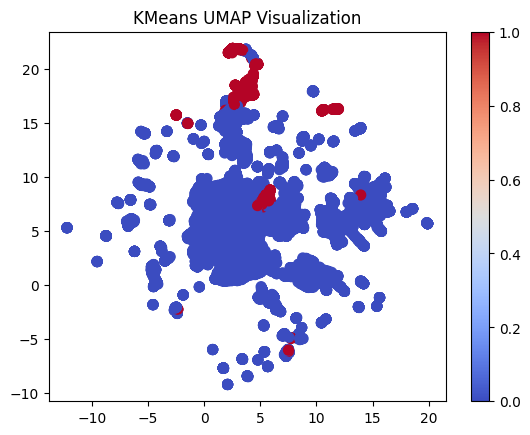

In [53]:
#KMeans UMAP Visualization

#%pip install umap-learn
import umap
import matplotlib.pyplot as plt

#Apply UMAP
reducer = umap.UMAP(random_state=42)
X_umap = reducer.fit_transform(airbnb_processed)

#Plot
plt.scatter(X_umap[:, 0], X_umap[:, 1], c=airbnb['kmeans_anomaly_k2'], cmap='coolwarm', s=50)
plt.colorbar()
plt.title("KMeans UMAP Visualization")
plt.show()


Clusters do not appear clearly defined.

Note: Red represents anomalies for DBSCAN

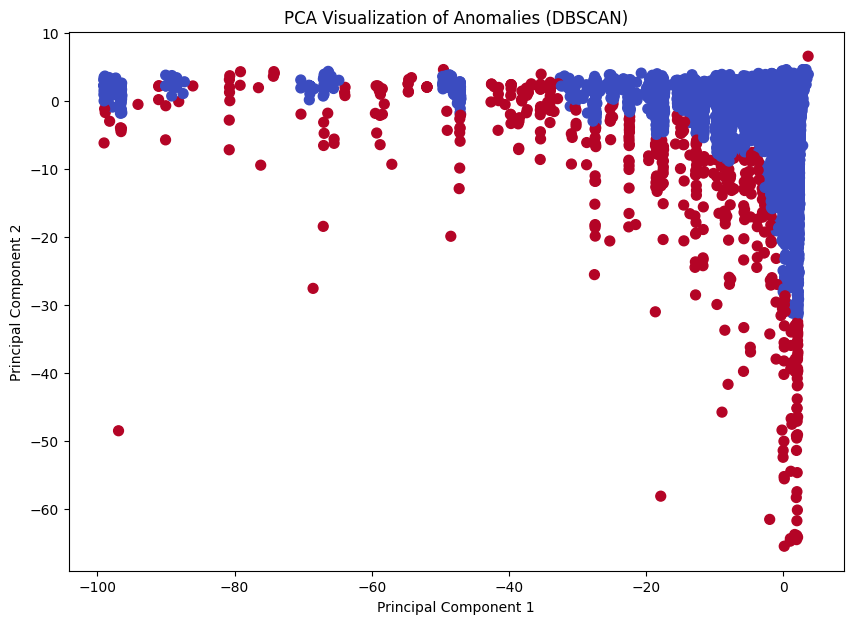

In [54]:
#Plot DBSCAN

#PCA
pca = PCA(n_components=2, random_state=42)
airbnb_reduced = pca.fit_transform(airbnb_processed)

plt.figure(figsize=(10, 7))
plt.scatter(airbnb_reduced[:, 0], airbnb_reduced[:, 1], c=airbnb['dbscan_anomaly_2'], cmap='coolwarm', s=50)
plt.title("PCA Visualization of Anomalies (DBSCAN)")
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

/anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


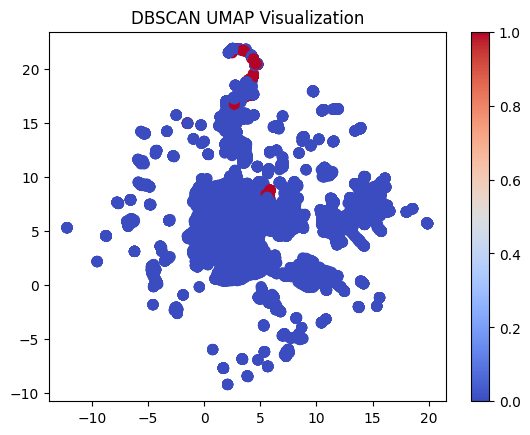

In [55]:
#DBSCAN UMAP Visualization

#%pip install umap-learn
import umap
import matplotlib.pyplot as plt

# Apply UMAP
reducer = umap.UMAP(random_state=42)
X_umap = reducer.fit_transform(airbnb_processed)

# Plot UMAP result
plt.scatter(X_umap[:, 0], X_umap[:, 1], c=airbnb['dbscan_anomaly_2'], cmap='coolwarm', s=50)
plt.colorbar()
plt.title("DBSCAN UMAP Visualization")
plt.show()




Once again, clusters do not appear clearly defined, but it seems that KMeans and DBSCAN are flagged similar areas as anomalies.

Next, we will use Jaccard Index to assess Model Overlap:

In [56]:
#Jaccard Index for Model Overlap - Best Models

#Isolation forest and Kmeans
set_model1 = set(airbnb[airbnb['isolation_forest_anomaly'] == -1].index)
set_model2 = set(airbnb[airbnb['kmeans_anomaly_k2'] == 1].index)

jaccard_index = len(set_model1 & set_model2) / len(set_model1 | set_model2)
print(f"Jaccard Index between Isolation Forest and KMeans: {jaccard_index}")

#Isolation Forest and DBSCAN
set_model1 = set(airbnb[airbnb['isolation_forest_anomaly'] == -1].index)
set_model2 = set(airbnb[airbnb['dbscan_anomaly_2'] == 1].index)

jaccard_index = len(set_model1 & set_model2) / len(set_model1 | set_model2)
print(f"Jaccard Index between Isolation Forest and DBSCAN: {jaccard_index}")

#DBSCAN and Kmean
set_model1 = set(airbnb[airbnb['dbscan_anomaly_2'] == 1].index)
set_model2 = set(airbnb[airbnb['kmeans_anomaly_k2'] == 1].index)

jaccard_index = len(set_model1 & set_model2) / len(set_model1 | set_model2)
print(f"Jaccard Index between DBSCAN and KMeans: {jaccard_index}")



Jaccard Index between Isolation Forest and KMeans: 0.1695196024295969
Jaccard Index between Isolation Forest and KMeans: 0.393526405451448
Jaccard Index between Isolation Forest and KMeans: 0.22797356828193832


This suggests that IsoForest and DBSCAN share the most overlap

We will plot a Venn Diagram to visualize this overlap:

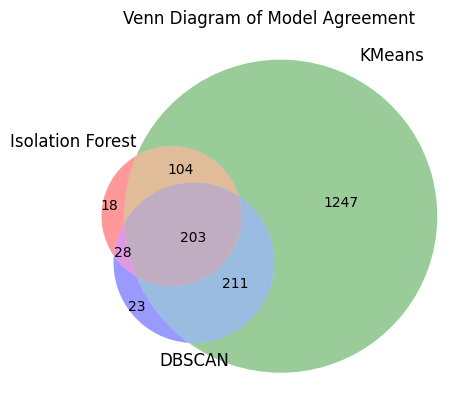

In [57]:
#%pip install matplotlib-venn
from matplotlib_venn import venn3

# Create Venn diagram for anomalies flagged by 3 models
set_model1 = set(airbnb[airbnb['isolation_forest_anomaly'] == -1].index)
set_model2 = set(airbnb[airbnb['kmeans_anomaly_k2'] == 1].index)
set_model3 = set(airbnb[airbnb['dbscan_anomaly_2'] == 1].index)

venn3([set_model1, set_model2, set_model3], set_labels=('Isolation Forest', 'KMeans', 'DBSCAN'))
plt.title("Venn Diagram of Model Agreement")
plt.show()

We can see here that 203 listings were flagged by all three models.

** We will now inspect and validate the flagged listings along with those found in our text mining analysis in the file FraudValidation.ipynb found in this folder. **